In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/ToyVortex.jl/")

  Activating environment at `/media/mat/HDD/ToyVortex.jl/Project.toml`


In [2]:
using Revise
using ToyVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions

┌ Info: Precompiling ToyVortex [ecedb753-2c01-4a22-98ba-d1067d7a6b00]
└ @ Base loading.jl:1342


In [3]:
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        legendfont = font("Computer Modern", 10),
        grid = false)
pyplot()
using LaTeXStrings
using StatsPlots

### Routines for the plots

In [4]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = state_to_lagrange(state, config.zs, config)
    plt = streamlines(X, Y, source, colorbar = false, 
                      xlim = (-2.2, 5), 
                      ylim = (-1.2*maximum(imag.(config.zs)), 1.2maximum(imag.(config.zs))); levels = 10)
    if withvortices == true
        plot!(plt, source, markersize = 12, markerstrokealpha = 0, 
              color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-1.0, 1.0), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    hline!(plt, [0.0], legend = false, color = :black)
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

function routine_plotCx(state, Cx::Matrix{Float64}, rx::Int64, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    
    U, S, _ = svd(Symmetric(Cx))
    source = state_to_lagrange(state, config.zs, config)
    
    # Default julia colors
    cur_colors = theme_palette(:auto)
    
    nlines = rx ÷ 3 + 1
    if mod(rx, 3) == 0
        nlines -= 1
    end
    
    plt = plot(layout = grid(nlines, 3))
    
    for i = 1:rx
        idxlines = (i÷3) + 1
        idxcols  = i - 3*(i÷3) 
        if mod(i, 3) == 0
            idxlines -= 1
            idxcols = 3
        end
        
        if withvortices == true
            for j=1:config.Nv
                # Put circles to show strength change
                scatter!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1]],
                      [state[(j-1)*3+2]],
                      markersize = 50*abs.(U[3*j,i]), markerstrokecolor = cur_colors[i],
                      markeralpha = 1.0, 
                      markerstrokewidth = 3,
                      markercolor = :white, legend = false)
            end
#             plot!(plt[idxlines, idxcols], source, markersize = 12, markeralpha = 0.5, 
#                   color = cgrad(reverse(colormap("RdBu")[10:end-10])),
#                   clim = (-1.0, 1.0), label = ["Vortices" "Sources"], legend = false, colorbar = false)
            plot!(plt[idxlines, idxcols],  xlim = (-2.0, 2.0), xticks = -2.0:1.0:2.0, 
                  ylim = (0, 1.2*maximum(imag.(config.zs))))

            for j=1:config.Nv
                # Put arrows to indicate directions of change
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] - U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] - U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] + U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] + U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
            end
        end
    end
    plt
end

routine_plotCx (generic function with 1 method)

### Configuration setup

In [5]:
#
Δtgif = 0.05

# Pressure sensors
Δs = 0.3
sensors = complex.(-1.5:Δs:3.5)
Ny = length(sensors)

Nclusters = 5
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.07
zclusters = [-2.0 + 0.4*im; -1.9 + 1.7*im; -1.8 + 0.8*im; -1.5 + 1.2*im; -1.4+ 0.4*im]
Nset = 4

config_data = let Nv = Nclusters*Nset, Ns = 1, zs = [2.0*im], Qs = [0.0], U = complex(1.0), 
             ss = sensors, Δt = 1e-2, δ = 1e-2,
             ϵX = 1e-4, ϵΓ = 1e-4, ϵQ = 1e-4,
             β = 1.0,
             ϵY = 5e-3
    VortexConfig(Nv, Ns, zs, Qs, U, ss, Δt, δ, ϵX, ϵΓ, ϵQ, β, ϵY)
end

Nv = config_data.Nv
Ns = config_data.Ns

xgrid = range(-3, 5, length=100)
ygrid = range(-1.2*maximum(imag.(config_data.zs)), 1.2*maximum(imag.(config_data.zs)), length=100)

t0 = 0.0
tf = 4.0
tspan = (t0, tf)

(0.0, 4.0)

### Generate the truth used in the twin experiment

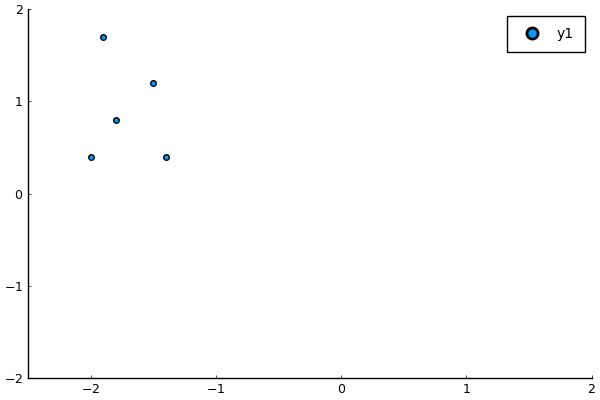

findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


In [6]:
scatter(real.(zclusters), imag.(zclusters), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0))

In [7]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
#         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1]


for i=1:Nclusters
    for j=1:Nset-1
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.1 + 0.05*randn()))
    end
        Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

source₊ = Ns >0 ? map(Source.Blob, config_data.zs, config_data.Qs, config_data.δ*ones(Ns)) : Source.Blob{Float64, Float64}[]
source₋ = Ns >0 ? map(Source.Blob, conj.(config_data.zs), config_data.Qs, config_data.δ*ones(Ns)) : Source.Blob{Float64, Float64}[]

sys = (vcat(blobs₊, blobs₋),  vcat(source₊, source₋...))

# data = generate_vortex(deepcopy(sys), t0, tf, config_data, "/media/mat/HDD/ToyVortex.jl/src/data/");
tt, x0, xt, yt = load("/media/mat/HDD/ToyVortex.jl/src/data/data_vortex_source.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, x0, xt, yt)

SyntheticData([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4.0], [-1.9668799594209685, 0.3543446125160898, 0.12781852762936896, -1.9644049342146022, 0.40516895797255126, 0.05941764676322123, -1.9911830813764355, 0.4392601660343183, 0.12449611985701431, -2.0098827156393755  …  -1.3841845681103082, 0.4017168319758957, 0.04998805916706946, -1.3942070757061529, 0.4272706719907281, 0.03200202164325071, -1.442214856158717, 0.4171458263628065, 1.0717895703065317, 0.0], [-1.966806320373129 -1.9165986935952701 … 4.235228301917931 4.258985582157114; 0.3545196900742175 0.3835548308770632 … 0.9207733122347371 0.9100032100776572; … ; 1.0716372757393617 1.0718607410950154 … 1.071675889751524 1.0717930513093672; 6.232134286180633e-5 0.0002514852833932021 … -8.099795630276016e-5 -1.907889373676758e-5], [-1.9300156197139815 -1.9847626816607846 … -0.465158217831007 -0.4650216886306453; -0.8328980262763458 -0.9626868672087574 … -0.47

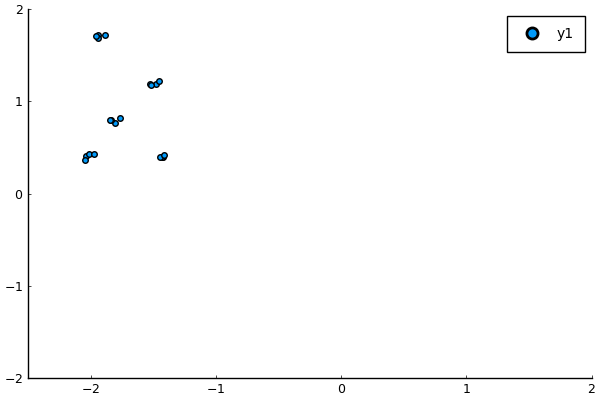

In [8]:
scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0))

In [ ]:
plt1 = routine_plot(data.xt[:,1], config_data, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(data.xt[:,end], config_data, xgrid, ygrid; withvortices = true)

plot(plt1, plt2)

In [10]:
# prog = Progress(length(t0:Δtgif:tf))

# @gif for tsnap in t0:Δtgif:tf
#     nsnap = ceil(Int64, tsnap/config_data.Δt)+1
#     plt1 = routine_plot(data.xt[:,nsnap], config_data, xgrid, ygrid; withvortices = true)
#     plt2 = plot(real(config_data.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config_data), xlim = (-Inf, Inf), 
#                 linewidth = 2, ylim = (-4.0, 0.0), color = :teal, legend = false, xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
#     plot(plt1, plt2)
# #     next!(prog)
# end

### Setup the sequential filter

In [11]:
# config = let Nv = Nclusters*Nset, Ns = 1, zs = [2.0*im], Qs = [1.0], U = complex(1.0), 
#              ss = sensors, Δt = 1e-2, δ = 1e-2,
#              ϵX = 5e-3, ϵΓ = 5e-3, ϵQ = 5e-3,
#              β = 1.0,
#              ϵY = 1e-2
#     VortexConfig(Nv, Ns, zs, Qs, U, ss, Δt, δ, ϵX, ϵΓ, ϵQ, β, ϵY)
# end

config = deepcopy(config_data)

VortexConfig(20, 1, ComplexF64[0.0 + 2.0im], [0.0], 1.0 + 0.0im, ComplexF64[-1.5 + 0.0im, -1.2 + 0.0im, -0.9 + 0.0im, -0.6 + 0.0im, -0.3 + 0.0im, 0.0 + 0.0im, 0.3 + 0.0im, 0.6 + 0.0im, 0.9 + 0.0im, 1.2 + 0.0im, 1.5 + 0.0im, 1.8 + 0.0im, 2.1 + 0.0im, 2.4 + 0.0im, 2.7 + 0.0im, 3.0 + 0.0im, 3.3 + 0.0im], 0.01, 0.01, 0.0001, 0.0001, 0.0001, 1.0, 0.005)

In [12]:
ϵX0 = 0.001
ϵΓ0 = 0.001
ϵQ0 = 0.001

ϵ0 = RecipeInflation([ϵX0; ϵΓ0; ϵQ0])

ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

AdditiveInflation(17, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.5e-5 0.0 … 0.0 0.0; 0.0 2.5e-5 … 0.0 0.0; … ; 0.0 0.0 … 2.5e-5 0.0; 0.0 0.0 … 0.0 2.5e-5], [0.005 0.0 … 0.0 0.0; 0.0 0.005 … 0.0 0.0; … ; 0.0 0.0 … 0.005 0.0; 0.0 0.0 … 0.0 0.005])

In [13]:
Ne = 100
Nx = 3*config.Nv + config.Ns
Ny = length(config.ss)

X0 = zeros(Ny+Nx, Ne)

X0[Ny+1:Ny+Nx,:] .= data.x0
ϵ0(X0, Ny, Nx)

In [14]:
enkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)

Stochastic EnKF  with filtered = true


In [15]:
# # Ne_tab = [20; 50; 80; 100]
# Nrun = 20

# # for Ne_i in Ne_tab
# Ne_i = 70
    
# rmse_lowrankenkf_tab = zeros(min(20,Nx), Ny, Nrun)
# rmse_enkf_tab = zeros(Nrun)

# X0 = zeros(Ny+Nx, Ne_i)
# X0[Ny+1:Ny+Nx,:] .= data.x0
# ϵ0(X0, Ny, Nx)
# @show "low-rank"
# Threads.@threads for i=1:min(20, Nx)
#     for j=1:Ny
#         for k=1:Nrun
#             @show i,j,k
#             Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; 
#                                                       rxdefault = i, rydefault = j)
#             rmse_lowrankenkf_tab[i,j,k] = deepcopy(norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1)))
#         end
#     end
#     save("/media/mat/HDD/ToyVortex.jl/notebooks/results/rmse_lowrankenkf_Ne_"*string(Ne_i)*".jld", 
#      "rmse_tab", rmse_lowrankenkf_tab)
# end
# save("/media/mat/HDD/ToyVortex.jl/notebooks/results/rmse_lowrankenkf_Ne_"*string(Ne_i)*".jld", 
#      "rmse_tab", rmse_lowrankenkf_tab)

# @show "full-rank"
# for k=1:Nrun
#     @show k
#     Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data)                                          
#     rmse_enkf_tab[k] = deepcopy(norm(mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1)))
# end

# save("/media/mat/HDD/ToyVortex.jl/notebooks/results/rmse_enkf_Ne_"*string(Ne_i)*".jld", 
#      "rmse_tab", rmse_enkf_tab)
# # end 

"low-rank" = "low-rank"
(i, j, k) = (11, 1, 1)
(i, j, k) = (16, 1, 1)
(i, j, k) = (1, 1, 1)
(i, j, k) = (6, 1, 1)
(i, j, k) = (16, 1, 2)
(i, j, k) = (1, 1, 2)
(i, j, k) = (6, 1, 2)
(i, j, k) = (11, 1, 2)
(i, j, k) = (16, 1, 3)
(i, j, k) = (16, 1, 4)
(i, j, k) = (1, 1, 3)
(i, j, k) = (6, 1, 3)
(i, j, k) = (16, 1, 5)
(i, j, k) = (11, 1, 3)
(i, j, k) = (1, 1, 4)
(i, j, k) = (16, 1, 6)
(i, j, k) = (6, 1, 4)
(i, j, k) = (11, 1, 4)
(i, j, k) = (1, 1, 5)
(i, j, k) = (16, 1, 7)
(i, j, k) = (11, 1, 5)
(i, j, k) = (6, 1, 5)
(i, j, k) = (1, 1, 6)
(i, j, k) = (16, 1, 8)
(i, j, k) = (11, 1, 6)
(i, j, k) = (6, 1, 6)
(i, j, k) = (1, 1, 7)
(i, j, k) = (16, 1, 9)
(i, j, k) = (6, 1, 7)
(i, j, k) = (11, 1, 7)
(i, j, k) = (1, 1, 8)
(i, j, k) = (16, 1, 10)
(i, j, k) = (6, 1, 8)
(i, j, k) = (11, 1, 8)
(i, j, k) = (1, 1, 9)
(i, j, k) = (16, 1, 11)
(i, j, k) = (6, 1, 9)
(i, j, k) = (11, 1, 9)
(i, j, k) = (1, 1, 10)
(i, j, k) = (16, 1, 12)
(i, j, k) = (6, 1, 10)
(i, j, k) = (11, 1, 10)
(i, j, k) = (1, 1, 11)
(

(i, j, k) = (6, 5, 8)
(i, j, k) = (16, 5, 11)
(i, j, k) = (6, 5, 9)
(i, j, k) = (11, 5, 11)
(i, j, k) = (1, 5, 11)
(i, j, k) = (6, 5, 10)
(i, j, k) = (16, 5, 12)
(i, j, k) = (11, 5, 12)
(i, j, k) = (6, 5, 11)
(i, j, k) = (1, 5, 12)
(i, j, k) = (16, 5, 13)
(i, j, k) = (11, 5, 13)
(i, j, k) = (6, 5, 12)
(i, j, k) = (1, 5, 13)
(i, j, k) = (11, 5, 14)
(i, j, k) = (16, 5, 14)
(i, j, k) = (6, 5, 13)
(i, j, k) = (1, 5, 14)
(i, j, k) = (11, 5, 15)
(i, j, k) = (16, 5, 15)
(i, j, k) = (6, 5, 14)
(i, j, k) = (11, 5, 16)
(i, j, k) = (1, 5, 15)
(i, j, k) = (16, 5, 16)
(i, j, k) = (6, 5, 15)
(i, j, k) = (11, 5, 17)
(i, j, k) = (16, 5, 17)
(i, j, k) = (1, 5, 16)
(i, j, k) = (6, 5, 16)
(i, j, k) = (11, 5, 18)
(i, j, k) = (16, 5, 18)
(i, j, k) = (1, 5, 17)
(i, j, k) = (6, 5, 17)
(i, j, k) = (16, 5, 19)
(i, j, k) = (11, 5, 19)
(i, j, k) = (11, 5, 20)
(i, j, k) = (1, 5, 18)
(i, j, k) = (6, 5, 18)
(i, j, k) = (16, 5, 20)
(i, j, k) = (11, 6, 1)
(i, j, k) = (6, 5, 19)
(i, j, k) = (1, 5, 19)
(i, j, k) = (16,

(i, j, k) = (16, 9, 18)
(i, j, k) = (6, 9, 19)
(i, j, k) = (11, 10, 1)
(i, j, k) = (1, 10, 1)
(i, j, k) = (16, 9, 19)
(i, j, k) = (6, 9, 20)
(i, j, k) = (11, 10, 2)
(i, j, k) = (1, 10, 2)
(i, j, k) = (16, 9, 20)
(i, j, k) = (1, 10, 3)
(i, j, k) = (6, 10, 1)
(i, j, k) = (11, 10, 3)
(i, j, k) = (16, 10, 1)
(i, j, k) = (1, 10, 4)
(i, j, k) = (16, 10, 2)
(i, j, k) = (6, 10, 2)
(i, j, k) = (11, 10, 4)
(i, j, k) = (1, 10, 5)
(i, j, k) = (16, 10, 3)
(i, j, k) = (6, 10, 3)
(i, j, k) = (11, 10, 5)
(i, j, k) = (1, 10, 6)
(i, j, k) = (16, 10, 4)
(i, j, k) = (6, 10, 4)
(i, j, k) = (11, 10, 6)
(i, j, k) = (6, 10, 5)
(i, j, k) = (1, 10, 7)
(i, j, k) = (16, 10, 5)
(i, j, k) = (6, 10, 6)
(i, j, k) = (11, 10, 7)
(i, j, k) = (6, 10, 7)
(i, j, k) = (16, 10, 6)
(i, j, k) = (1, 10, 8)
(i, j, k) = (11, 10, 8)
(i, j, k) = (6, 10, 8)
(i, j, k) = (16, 10, 7)
(i, j, k) = (16, 10, 8)
(i, j, k) = (1, 10, 9)
(i, j, k) = (11, 10, 9)
(i, j, k) = (16, 10, 9)
(i, j, k) = (6, 10, 9)
(i, j, k) = (11, 10, 10)
(i, j, k) =

(i, j, k) = (11, 14, 7)
(i, j, k) = (16, 14, 11)
(i, j, k) = (6, 14, 5)
(i, j, k) = (1, 13, 18)
(i, j, k) = (11, 14, 8)
(i, j, k) = (6, 14, 6)
(i, j, k) = (16, 14, 12)
(i, j, k) = (1, 13, 19)
(i, j, k) = (11, 14, 9)
(i, j, k) = (6, 14, 7)
(i, j, k) = (16, 14, 13)
(i, j, k) = (1, 13, 20)
(i, j, k) = (11, 14, 10)
(i, j, k) = (6, 14, 8)
(i, j, k) = (16, 14, 14)
(i, j, k) = (1, 14, 1)
(i, j, k) = (11, 14, 11)
(i, j, k) = (6, 14, 9)
(i, j, k) = (16, 14, 15)
(i, j, k) = (1, 14, 2)
(i, j, k) = (11, 14, 12)
(i, j, k) = (6, 14, 10)
(i, j, k) = (16, 14, 16)
(i, j, k) = (1, 14, 3)
(i, j, k) = (11, 14, 13)
(i, j, k) = (6, 14, 11)
(i, j, k) = (16, 14, 17)
(i, j, k) = (1, 14, 4)
(i, j, k) = (11, 14, 14)
(i, j, k) = (6, 14, 12)
(i, j, k) = (16, 14, 18)
(i, j, k) = (6, 14, 13)
(i, j, k) = (1, 14, 5)
(i, j, k) = (11, 14, 15)
(i, j, k) = (6, 14, 14)
(i, j, k) = (6, 14, 15)
(i, j, k) = (16, 14, 19)
(i, j, k) = (6, 14, 16)
(i, j, k) = (1, 14, 6)
(i, j, k) = (11, 14, 16)
(i, j, k) = (6, 14, 17)
(i, j, k) =

(i, j, k) = (12, 1, 12)
(i, j, k) = (17, 2, 7)
(i, j, k) = (7, 1, 4)
(i, j, k) = (2, 1, 3)
(i, j, k) = (12, 1, 13)
(i, j, k) = (17, 2, 8)
(i, j, k) = (7, 1, 5)
(i, j, k) = (2, 1, 4)
(i, j, k) = (12, 1, 14)
(i, j, k) = (2, 1, 5)
(i, j, k) = (17, 2, 9)
(i, j, k) = (2, 1, 6)
(i, j, k) = (7, 1, 6)
(i, j, k) = (2, 1, 7)
(i, j, k) = (12, 1, 15)
(i, j, k) = (17, 2, 10)
(i, j, k) = (2, 1, 8)
(i, j, k) = (7, 1, 7)
(i, j, k) = (12, 1, 16)
(i, j, k) = (17, 2, 11)
(i, j, k) = (2, 1, 9)
(i, j, k) = (7, 1, 8)
(i, j, k) = (12, 1, 17)
(i, j, k) = (17, 2, 12)
(i, j, k) = (2, 1, 10)
(i, j, k) = (7, 1, 9)
(i, j, k) = (12, 1, 18)
(i, j, k) = (17, 2, 13)
(i, j, k) = (2, 1, 11)
(i, j, k) = (7, 1, 10)
(i, j, k) = (12, 1, 19)
(i, j, k) = (17, 2, 14)
(i, j, k) = (2, 1, 12)
(i, j, k) = (7, 1, 11)
(i, j, k) = (12, 1, 20)
(i, j, k) = (7, 1, 12)
(i, j, k) = (17, 2, 15)
(i, j, k) = (2, 1, 13)
(i, j, k) = (17, 2, 16)
(i, j, k) = (7, 1, 13)
(i, j, k) = (12, 2, 1)
(i, j, k) = (17, 2, 17)
(i, j, k) = (2, 1, 14)
(i, j, 

(i, j, k) = (7, 6, 2)
(i, j, k) = (12, 5, 13)
(i, j, k) = (2, 5, 13)
(i, j, k) = (17, 6, 14)
(i, j, k) = (7, 6, 3)
(i, j, k) = (12, 5, 14)
(i, j, k) = (2, 5, 14)
(i, j, k) = (17, 6, 15)
(i, j, k) = (7, 6, 4)
(i, j, k) = (12, 5, 15)
(i, j, k) = (2, 5, 15)
(i, j, k) = (17, 6, 16)
(i, j, k) = (7, 6, 5)
(i, j, k) = (12, 5, 16)
(i, j, k) = (2, 5, 16)
(i, j, k) = (17, 6, 17)
(i, j, k) = (7, 6, 6)
(i, j, k) = (2, 5, 17)
(i, j, k) = (12, 5, 17)
(i, j, k) = (2, 5, 18)
(i, j, k) = (2, 5, 19)
(i, j, k) = (17, 6, 18)
(i, j, k) = (7, 6, 7)
(i, j, k) = (12, 5, 18)
(i, j, k) = (2, 5, 20)
(i, j, k) = (2, 6, 1)
(i, j, k) = (7, 6, 8)
(i, j, k) = (17, 6, 19)
(i, j, k) = (12, 5, 19)
(i, j, k) = (12, 5, 20)
(i, j, k) = (2, 6, 2)
(i, j, k) = (7, 6, 9)
(i, j, k) = (12, 6, 1)
(i, j, k) = (17, 6, 20)
(i, j, k) = (12, 6, 2)
(i, j, k) = (2, 6, 3)
(i, j, k) = (12, 6, 3)
(i, j, k) = (7, 6, 10)
(i, j, k) = (17, 7, 1)
(i, j, k) = (12, 6, 4)
(i, j, k) = (12, 6, 5)
(i, j, k) = (2, 6, 4)
(i, j, k) = (7, 6, 11)
(i, j, k

(i, j, k) = (17, 11, 7)
(i, j, k) = (12, 10, 1)
(i, j, k) = (7, 10, 7)
(i, j, k) = (2, 10, 3)
(i, j, k) = (17, 11, 8)
(i, j, k) = (12, 10, 2)
(i, j, k) = (7, 10, 8)
(i, j, k) = (2, 10, 4)
(i, j, k) = (17, 11, 9)
(i, j, k) = (12, 10, 3)
(i, j, k) = (7, 10, 9)
(i, j, k) = (2, 10, 5)
(i, j, k) = (17, 11, 10)
(i, j, k) = (12, 10, 4)
(i, j, k) = (7, 10, 10)
(i, j, k) = (2, 10, 6)
(i, j, k) = (17, 11, 11)
(i, j, k) = (12, 10, 5)
(i, j, k) = (7, 10, 11)
(i, j, k) = (2, 10, 7)
(i, j, k) = (17, 11, 12)
(i, j, k) = (7, 10, 12)
(i, j, k) = (12, 10, 6)
(i, j, k) = (2, 10, 8)
(i, j, k) = (7, 10, 13)
(i, j, k) = (17, 11, 13)
(i, j, k) = (7, 10, 14)
(i, j, k) = (12, 10, 7)
(i, j, k) = (7, 10, 15)
(i, j, k) = (2, 10, 9)
(i, j, k) = (17, 11, 14)
(i, j, k) = (12, 10, 8)
(i, j, k) = (7, 10, 16)
(i, j, k) = (2, 10, 10)
(i, j, k) = (17, 11, 15)
(i, j, k) = (12, 10, 9)
(i, j, k) = (17, 11, 16)
(i, j, k) = (7, 10, 17)
(i, j, k) = (2, 10, 11)
(i, j, k) = (12, 10, 10)
(i, j, k) = (17, 11, 17)
(i, j, k) = (7, 1

(i, j, k) = (2, 14, 3)
(i, j, k) = (12, 14, 4)
(i, j, k) = (2, 14, 4)
(i, j, k) = (7, 14, 18)
(i, j, k) = (2, 14, 5)
(i, j, k) = (17, 15, 14)
(i, j, k) = (12, 14, 5)
(i, j, k) = (2, 14, 6)
(i, j, k) = (7, 14, 19)
(i, j, k) = (12, 14, 6)
(i, j, k) = (17, 15, 15)
(i, j, k) = (12, 14, 7)
(i, j, k) = (2, 14, 7)
(i, j, k) = (12, 14, 8)
(i, j, k) = (7, 14, 20)
(i, j, k) = (12, 14, 9)
(i, j, k) = (17, 15, 16)
(i, j, k) = (2, 14, 8)
(i, j, k) = (7, 15, 1)
(i, j, k) = (12, 14, 10)
(i, j, k) = (17, 15, 17)
(i, j, k) = (7, 15, 2)
(i, j, k) = (12, 14, 11)
(i, j, k) = (7, 15, 3)
(i, j, k) = (2, 14, 9)
(i, j, k) = (7, 15, 4)
(i, j, k) = (17, 15, 18)
(i, j, k) = (7, 15, 5)
(i, j, k) = (12, 14, 12)
(i, j, k) = (2, 14, 10)
(i, j, k) = (7, 15, 6)
(i, j, k) = (17, 15, 19)
(i, j, k) = (7, 15, 7)
(i, j, k) = (12, 14, 13)
(i, j, k) = (7, 15, 8)
(i, j, k) = (2, 14, 11)
(i, j, k) = (7, 15, 9)
(i, j, k) = (17, 15, 20)
(i, j, k) = (7, 15, 10)
(i, j, k) = (12, 14, 14)
(i, j, k) = (2, 14, 12)
(i, j, k) = (7, 15, 

(i, j, k) = (8, 3, 9)
(i, j, k) = (8, 3, 10)
(i, j, k) = (18, 2, 8)
(i, j, k) = (13, 1, 3)
(i, j, k) = (3, 1, 9)
(i, j, k) = (8, 3, 11)
(i, j, k) = (18, 2, 9)
(i, j, k) = (13, 1, 4)
(i, j, k) = (3, 1, 10)
(i, j, k) = (8, 3, 12)
(i, j, k) = (8, 3, 13)
(i, j, k) = (18, 2, 10)
(i, j, k) = (13, 1, 5)
(i, j, k) = (3, 1, 11)
(i, j, k) = (8, 3, 14)
(i, j, k) = (8, 3, 15)
(i, j, k) = (18, 2, 11)
(i, j, k) = (13, 1, 6)
(i, j, k) = (8, 3, 16)
(i, j, k) = (3, 1, 12)
(i, j, k) = (8, 3, 17)
(i, j, k) = (8, 3, 18)
(i, j, k) = (18, 2, 12)
(i, j, k) = (13, 1, 7)
(i, j, k) = (3, 1, 13)
(i, j, k) = (8, 3, 19)
(i, j, k) = (8, 3, 20)
(i, j, k) = (18, 2, 13)
(i, j, k) = (13, 1, 8)
(i, j, k) = (8, 4, 1)
(i, j, k) = (3, 1, 14)
(i, j, k) = (8, 4, 2)
(i, j, k) = (8, 4, 3)
(i, j, k) = (18, 2, 14)
(i, j, k) = (13, 1, 9)
(i, j, k) = (3, 1, 15)
(i, j, k) = (8, 4, 4)
(i, j, k) = (8, 4, 5)
(i, j, k) = (18, 2, 15)
(i, j, k) = (13, 1, 10)
(i, j, k) = (8, 4, 6)
(i, j, k) = (3, 1, 16)
(i, j, k) = (8, 4, 7)
(i, j, k) = (

(i, j, k) = (13, 5, 4)
(i, j, k) = (3, 5, 12)
(i, j, k) = (18, 6, 18)
(i, j, k) = (8, 8, 12)
(i, j, k) = (3, 5, 13)
(i, j, k) = (13, 5, 5)
(i, j, k) = (3, 5, 14)
(i, j, k) = (18, 6, 19)
(i, j, k) = (8, 8, 13)
(i, j, k) = (3, 5, 15)
(i, j, k) = (13, 5, 6)
(i, j, k) = (3, 5, 16)
(i, j, k) = (18, 6, 20)
(i, j, k) = (3, 5, 17)
(i, j, k) = (8, 8, 14)
(i, j, k) = (13, 5, 7)
(i, j, k) = (3, 5, 18)
(i, j, k) = (18, 7, 1)
(i, j, k) = (3, 5, 19)
(i, j, k) = (8, 8, 15)
(i, j, k) = (13, 5, 8)
(i, j, k) = (18, 7, 2)
(i, j, k) = (3, 5, 20)
(i, j, k) = (8, 8, 16)
(i, j, k) = (13, 5, 9)
(i, j, k) = (18, 7, 3)
(i, j, k) = (3, 6, 1)
(i, j, k) = (8, 8, 17)
(i, j, k) = (13, 5, 10)
(i, j, k) = (18, 7, 4)
(i, j, k) = (3, 6, 2)
(i, j, k) = (8, 8, 18)
(i, j, k) = (13, 5, 11)
(i, j, k) = (18, 7, 5)
(i, j, k) = (3, 6, 3)
(i, j, k) = (8, 8, 19)
(i, j, k) = (13, 5, 12)
(i, j, k) = (8, 8, 20)
(i, j, k) = (18, 7, 6)
(i, j, k) = (3, 6, 4)
(i, j, k) = (13, 5, 13)
(i, j, k) = (8, 9, 1)
(i, j, k) = (18, 7, 7)
(i, j, k)

(i, j, k) = (13, 9, 9)
(i, j, k) = (8, 12, 20)
(i, j, k) = (18, 10, 18)
(i, j, k) = (3, 10, 14)
(i, j, k) = (13, 9, 10)
(i, j, k) = (8, 13, 1)
(i, j, k) = (18, 10, 19)
(i, j, k) = (3, 10, 15)
(i, j, k) = (13, 9, 11)
(i, j, k) = (8, 13, 2)
(i, j, k) = (18, 10, 20)
(i, j, k) = (3, 10, 16)
(i, j, k) = (13, 9, 12)
(i, j, k) = (8, 13, 3)
(i, j, k) = (18, 11, 1)
(i, j, k) = (3, 10, 17)
(i, j, k) = (13, 9, 13)
(i, j, k) = (8, 13, 4)
(i, j, k) = (18, 11, 2)
(i, j, k) = (3, 10, 18)
(i, j, k) = (13, 9, 14)
(i, j, k) = (8, 13, 5)
(i, j, k) = (18, 11, 3)
(i, j, k) = (3, 10, 19)
(i, j, k) = (13, 9, 15)
(i, j, k) = (8, 13, 6)
(i, j, k) = (8, 13, 7)
(i, j, k) = (18, 11, 4)
(i, j, k) = (3, 10, 20)
(i, j, k) = (8, 13, 8)
(i, j, k) = (13, 9, 16)
(i, j, k) = (8, 13, 9)
(i, j, k) = (18, 11, 5)
(i, j, k) = (3, 11, 1)
(i, j, k) = (13, 9, 17)
(i, j, k) = (8, 13, 10)
(i, j, k) = (8, 13, 11)
(i, j, k) = (18, 11, 6)
(i, j, k) = (3, 11, 2)
(i, j, k) = (8, 13, 12)
(i, j, k) = (13, 9, 18)
(i, j, k) = (8, 13, 13)
(

(i, j, k) = (8, 17, 9)
(i, j, k) = (13, 13, 8)
(i, j, k) = (18, 15, 8)
(i, j, k) = (8, 17, 10)
(i, j, k) = (3, 14, 19)
(i, j, k) = (8, 17, 11)
(i, j, k) = (13, 13, 9)
(i, j, k) = (18, 15, 9)
(i, j, k) = (13, 13, 10)
(i, j, k) = (8, 17, 12)
(i, j, k) = (3, 14, 20)
(i, j, k) = (13, 13, 11)
(i, j, k) = (18, 15, 10)
(i, j, k) = (8, 17, 13)
(i, j, k) = (13, 13, 12)
(i, j, k) = (3, 15, 1)
(i, j, k) = (18, 15, 11)
(i, j, k) = (8, 17, 14)
(i, j, k) = (13, 13, 13)
(i, j, k) = (3, 15, 2)
(i, j, k) = (18, 15, 12)
(i, j, k) = (8, 17, 15)
(i, j, k) = (13, 13, 14)
(i, j, k) = (3, 15, 3)
(i, j, k) = (18, 15, 13)
(i, j, k) = (8, 17, 16)
(i, j, k) = (13, 13, 15)
(i, j, k) = (3, 15, 4)
(i, j, k) = (18, 15, 14)
(i, j, k) = (8, 17, 17)
(i, j, k) = (13, 13, 16)
(i, j, k) = (3, 15, 5)
(i, j, k) = (18, 15, 15)
(i, j, k) = (8, 17, 18)
(i, j, k) = (13, 13, 17)
(i, j, k) = (3, 15, 6)
(i, j, k) = (18, 15, 16)
(i, j, k) = (8, 17, 19)
(i, j, k) = (13, 13, 18)
(i, j, k) = (3, 15, 7)
(i, j, k) = (18, 15, 17)
(i, j, 

(i, j, k) = (19, 2, 20)
(i, j, k) = (4, 2, 11)
(i, j, k) = (13, 17, 9)
(i, j, k) = (4, 2, 12)
(i, j, k) = (9, 4, 14)
(i, j, k) = (19, 3, 1)
(i, j, k) = (4, 2, 13)
(i, j, k) = (13, 17, 10)
(i, j, k) = (9, 4, 15)
(i, j, k) = (4, 2, 14)
(i, j, k) = (19, 3, 2)
(i, j, k) = (13, 17, 11)
(i, j, k) = (9, 4, 16)
(i, j, k) = (4, 2, 15)
(i, j, k) = (19, 3, 3)
(i, j, k) = (13, 17, 12)
(i, j, k) = (9, 4, 17)
(i, j, k) = (4, 2, 16)
(i, j, k) = (19, 3, 4)
(i, j, k) = (13, 17, 13)
(i, j, k) = (9, 4, 18)
(i, j, k) = (4, 2, 17)
(i, j, k) = (19, 3, 5)
(i, j, k) = (9, 4, 19)
(i, j, k) = (13, 17, 14)
(i, j, k) = (9, 4, 20)
(i, j, k) = (4, 2, 18)
(i, j, k) = (19, 3, 6)
(i, j, k) = (13, 17, 15)
(i, j, k) = (9, 5, 1)
(i, j, k) = (4, 2, 19)
(i, j, k) = (19, 3, 7)
(i, j, k) = (13, 17, 16)
(i, j, k) = (4, 2, 20)
(i, j, k) = (4, 3, 1)
(i, j, k) = (9, 5, 2)
(i, j, k) = (19, 3, 8)
(i, j, k) = (13, 17, 17)
(i, j, k) = (4, 3, 2)
(i, j, k) = (9, 5, 3)
(i, j, k) = (19, 3, 9)
(i, j, k) = (13, 17, 18)
(i, j, k) = (4, 3, 

(i, j, k) = (14, 5, 14)
(i, j, k) = (14, 5, 15)
(i, j, k) = (9, 8, 17)
(i, j, k) = (19, 7, 4)
(i, j, k) = (14, 5, 16)
(i, j, k) = (4, 6, 18)
(i, j, k) = (14, 5, 17)
(i, j, k) = (9, 8, 18)
(i, j, k) = (14, 5, 18)
(i, j, k) = (19, 7, 5)
(i, j, k) = (4, 6, 19)
(i, j, k) = (14, 5, 19)
(i, j, k) = (9, 8, 19)
(i, j, k) = (19, 7, 6)
(i, j, k) = (4, 6, 20)
(i, j, k) = (14, 5, 20)
(i, j, k) = (9, 8, 20)
(i, j, k) = (19, 7, 7)
(i, j, k) = (4, 7, 1)
(i, j, k) = (14, 6, 1)
(i, j, k) = (19, 7, 8)
(i, j, k) = (9, 9, 1)
(i, j, k) = (14, 6, 2)
(i, j, k) = (4, 7, 2)
(i, j, k) = (19, 7, 9)
(i, j, k) = (9, 9, 2)
(i, j, k) = (14, 6, 3)
(i, j, k) = (4, 7, 3)
(i, j, k) = (19, 7, 10)
(i, j, k) = (9, 9, 3)
(i, j, k) = (14, 6, 4)
(i, j, k) = (19, 7, 11)
(i, j, k) = (4, 7, 4)
(i, j, k) = (4, 7, 5)
(i, j, k) = (9, 9, 4)
(i, j, k) = (14, 6, 5)
(i, j, k) = (19, 7, 12)
(i, j, k) = (4, 7, 6)
(i, j, k) = (9, 9, 5)
(i, j, k) = (14, 6, 6)
(i, j, k) = (4, 7, 7)
(i, j, k) = (19, 7, 13)
(i, j, k) = (9, 9, 6)
(i, j, k) = (

(i, j, k) = (14, 10, 13)
(i, j, k) = (19, 11, 16)
(i, j, k) = (14, 10, 14)
(i, j, k) = (9, 12, 15)
(i, j, k) = (14, 10, 15)
(i, j, k) = (4, 10, 20)
(i, j, k) = (19, 11, 17)
(i, j, k) = (14, 10, 16)
(i, j, k) = (9, 12, 16)
(i, j, k) = (14, 10, 17)
(i, j, k) = (4, 11, 1)
(i, j, k) = (14, 10, 18)
(i, j, k) = (19, 11, 18)
(i, j, k) = (14, 10, 19)
(i, j, k) = (9, 12, 17)
(i, j, k) = (14, 10, 20)
(i, j, k) = (4, 11, 2)
(i, j, k) = (19, 11, 19)
(i, j, k) = (9, 12, 18)
(i, j, k) = (14, 11, 1)
(i, j, k) = (4, 11, 3)
(i, j, k) = (19, 11, 20)
(i, j, k) = (9, 12, 19)
(i, j, k) = (14, 11, 2)
(i, j, k) = (4, 11, 4)
(i, j, k) = (19, 12, 1)
(i, j, k) = (9, 12, 20)
(i, j, k) = (14, 11, 3)
(i, j, k) = (4, 11, 5)
(i, j, k) = (19, 12, 2)
(i, j, k) = (9, 13, 1)
(i, j, k) = (14, 11, 4)
(i, j, k) = (4, 11, 6)
(i, j, k) = (19, 12, 3)
(i, j, k) = (9, 13, 2)
(i, j, k) = (14, 11, 5)
(i, j, k) = (4, 11, 7)
(i, j, k) = (19, 12, 4)
(i, j, k) = (4, 11, 8)
(i, j, k) = (9, 13, 3)
(i, j, k) = (14, 11, 6)
(i, j, k) = (1

(i, j, k) = (14, 15, 5)
(i, j, k) = (4, 15, 11)
(i, j, k) = (9, 16, 17)
(i, j, k) = (19, 15, 13)
(i, j, k) = (4, 15, 12)
(i, j, k) = (4, 15, 13)
(i, j, k) = (14, 15, 6)
(i, j, k) = (9, 16, 18)
(i, j, k) = (19, 15, 14)
(i, j, k) = (4, 15, 14)
(i, j, k) = (14, 15, 7)
(i, j, k) = (9, 16, 19)
(i, j, k) = (19, 15, 15)
(i, j, k) = (4, 15, 15)
(i, j, k) = (14, 15, 8)
(i, j, k) = (9, 16, 20)
(i, j, k) = (19, 15, 16)
(i, j, k) = (4, 15, 16)
(i, j, k) = (14, 15, 9)
(i, j, k) = (9, 17, 1)
(i, j, k) = (19, 15, 17)
(i, j, k) = (4, 15, 17)
(i, j, k) = (9, 17, 2)
(i, j, k) = (14, 15, 10)
(i, j, k) = (19, 15, 18)
(i, j, k) = (9, 17, 3)
(i, j, k) = (9, 17, 4)
(i, j, k) = (4, 15, 18)
(i, j, k) = (14, 15, 11)
(i, j, k) = (9, 17, 5)
(i, j, k) = (19, 15, 19)
(i, j, k) = (4, 15, 19)
(i, j, k) = (9, 17, 6)
(i, j, k) = (14, 15, 12)
(i, j, k) = (19, 15, 20)
(i, j, k) = (4, 15, 20)
(i, j, k) = (9, 17, 7)
(i, j, k) = (14, 15, 13)
(i, j, k) = (19, 16, 1)
(i, j, k) = (4, 16, 1)
(i, j, k) = (9, 17, 8)
(i, j, k) = (

(i, j, k) = (20, 2, 11)
(i, j, k) = (15, 2, 18)
(i, j, k) = (10, 4, 3)
(i, j, k) = (15, 2, 19)
(i, j, k) = (5, 2, 19)
(i, j, k) = (15, 2, 20)
(i, j, k) = (20, 2, 12)
(i, j, k) = (15, 3, 1)
(i, j, k) = (10, 4, 4)
(i, j, k) = (15, 3, 2)
(i, j, k) = (5, 2, 20)
(i, j, k) = (20, 2, 13)
(i, j, k) = (15, 3, 3)
(i, j, k) = (10, 4, 5)
(i, j, k) = (20, 2, 14)
(i, j, k) = (5, 3, 1)
(i, j, k) = (15, 3, 4)
(i, j, k) = (10, 4, 6)
(i, j, k) = (20, 2, 15)
(i, j, k) = (5, 3, 2)
(i, j, k) = (15, 3, 5)
(i, j, k) = (10, 4, 7)
(i, j, k) = (20, 2, 16)
(i, j, k) = (5, 3, 3)
(i, j, k) = (15, 3, 6)
(i, j, k) = (10, 4, 8)
(i, j, k) = (5, 3, 4)
(i, j, k) = (20, 2, 17)
(i, j, k) = (15, 3, 7)
(i, j, k) = (10, 4, 9)
(i, j, k) = (5, 3, 5)
(i, j, k) = (20, 2, 18)
(i, j, k) = (15, 3, 8)
(i, j, k) = (10, 4, 10)
(i, j, k) = (5, 3, 6)
(i, j, k) = (20, 2, 19)
(i, j, k) = (15, 3, 9)
(i, j, k) = (10, 4, 11)
(i, j, k) = (5, 3, 7)
(i, j, k) = (20, 2, 20)
(i, j, k) = (15, 3, 10)
(i, j, k) = (10, 4, 12)
(i, j, k) = (5, 3, 8)
(i

(i, j, k) = (15, 7, 5)
(i, j, k) = (20, 6, 19)
(i, j, k) = (20, 6, 20)
(i, j, k) = (10, 8, 10)
(i, j, k) = (5, 7, 9)
(i, j, k) = (20, 7, 1)
(i, j, k) = (15, 7, 6)
(i, j, k) = (10, 8, 11)
(i, j, k) = (20, 7, 2)
(i, j, k) = (5, 7, 10)
(i, j, k) = (15, 7, 7)
(i, j, k) = (10, 8, 12)
(i, j, k) = (20, 7, 3)
(i, j, k) = (5, 7, 11)
(i, j, k) = (15, 7, 8)
(i, j, k) = (10, 8, 13)
(i, j, k) = (20, 7, 4)
(i, j, k) = (5, 7, 12)
(i, j, k) = (15, 7, 9)
(i, j, k) = (10, 8, 14)
(i, j, k) = (20, 7, 5)
(i, j, k) = (5, 7, 13)
(i, j, k) = (15, 7, 10)
(i, j, k) = (15, 7, 11)
(i, j, k) = (10, 8, 15)
(i, j, k) = (15, 7, 12)
(i, j, k) = (20, 7, 6)
(i, j, k) = (5, 7, 14)
(i, j, k) = (15, 7, 13)
(i, j, k) = (10, 8, 16)
(i, j, k) = (10, 8, 17)
(i, j, k) = (20, 7, 7)
(i, j, k) = (5, 7, 15)
(i, j, k) = (15, 7, 14)
(i, j, k) = (10, 8, 18)
(i, j, k) = (10, 8, 19)
(i, j, k) = (20, 7, 8)
(i, j, k) = (5, 7, 16)
(i, j, k) = (10, 8, 20)
(i, j, k) = (15, 7, 15)
(i, j, k) = (10, 9, 1)
(i, j, k) = (10, 9, 2)
(i, j, k) = (20,

(i, j, k) = (15, 11, 4)
(i, j, k) = (20, 11, 7)
(i, j, k) = (10, 13, 1)
(i, j, k) = (5, 11, 18)
(i, j, k) = (15, 11, 5)
(i, j, k) = (20, 11, 8)
(i, j, k) = (10, 13, 2)
(i, j, k) = (15, 11, 6)
(i, j, k) = (5, 11, 19)
(i, j, k) = (20, 11, 9)
(i, j, k) = (10, 13, 3)
(i, j, k) = (15, 11, 7)
(i, j, k) = (5, 11, 20)
(i, j, k) = (20, 11, 10)
(i, j, k) = (10, 13, 4)
(i, j, k) = (15, 11, 8)
(i, j, k) = (5, 12, 1)
(i, j, k) = (20, 11, 11)
(i, j, k) = (15, 11, 9)
(i, j, k) = (10, 13, 5)
(i, j, k) = (15, 11, 10)
(i, j, k) = (5, 12, 2)
(i, j, k) = (20, 11, 12)
(i, j, k) = (15, 11, 11)
(i, j, k) = (10, 13, 6)
(i, j, k) = (15, 11, 12)
(i, j, k) = (5, 12, 3)
(i, j, k) = (15, 11, 13)
(i, j, k) = (20, 11, 13)
(i, j, k) = (15, 11, 14)
(i, j, k) = (10, 13, 7)
(i, j, k) = (15, 11, 15)
(i, j, k) = (5, 12, 4)
(i, j, k) = (20, 11, 14)
(i, j, k) = (15, 11, 16)
(i, j, k) = (10, 13, 8)
(i, j, k) = (15, 11, 17)
(i, j, k) = (5, 12, 5)
(i, j, k) = (15, 11, 18)
(i, j, k) = (20, 11, 15)
(i, j, k) = (10, 13, 9)
(i, j,

(i, j, k) = (20, 15, 11)
(i, j, k) = (10, 17, 6)
(i, j, k) = (15, 15, 7)
(i, j, k) = (5, 16, 5)
(i, j, k) = (15, 15, 8)
(i, j, k) = (20, 15, 12)
(i, j, k) = (10, 17, 7)
(i, j, k) = (15, 15, 9)
(i, j, k) = (15, 15, 10)
(i, j, k) = (5, 16, 6)
(i, j, k) = (20, 15, 13)
(i, j, k) = (10, 17, 8)
(i, j, k) = (15, 15, 11)
(i, j, k) = (5, 16, 7)
(i, j, k) = (20, 15, 14)
(i, j, k) = (10, 17, 9)
(i, j, k) = (15, 15, 12)
(i, j, k) = (5, 16, 8)
(i, j, k) = (20, 15, 15)
(i, j, k) = (10, 17, 10)
(i, j, k) = (15, 15, 13)
(i, j, k) = (5, 16, 9)
(i, j, k) = (10, 17, 11)
(i, j, k) = (20, 15, 16)
(i, j, k) = (15, 15, 14)
(i, j, k) = (5, 16, 10)
(i, j, k) = (10, 17, 12)
(i, j, k) = (20, 15, 17)
(i, j, k) = (15, 15, 15)
(i, j, k) = (5, 16, 11)
(i, j, k) = (10, 17, 13)
(i, j, k) = (20, 15, 18)
(i, j, k) = (15, 15, 16)
(i, j, k) = (5, 16, 12)
(i, j, k) = (10, 17, 14)
(i, j, k) = (20, 15, 19)
(i, j, k) = (15, 15, 17)
(i, j, k) = (5, 16, 13)
(i, j, k) = (10, 17, 15)
(i, j, k) = (20, 15, 20)
(i, j, k) = (15, 15, 

In [16]:
# Ne_tab = [20; 50; 80; 100]
Nrun = 20

# for Ne_i in Ne_tab
Ne_i = 120
    
rmse_lowrankenkf_tab = zeros(min(20,Nx), Ny, Nrun)
rmse_enkf_tab = zeros(Nrun)

X0 = zeros(Ny+Nx, Ne_i)
X0[Ny+1:Ny+Nx,:] .= data.x0
ϵ0(X0, Ny, Nx)
@show "low-rank"
Threads.@threads for i=1:min(20, Nx)
    for j=1:Ny
        for k=1:Nrun
            @show i,j,k
            Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; 
                                                      rxdefault = i, rydefault = j)
            rmse_lowrankenkf_tab[i,j,k] = deepcopy(norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1)))
        end
    end
end
save("/media/mat/HDD/ToyVortex.jl/notebooks/results/rmse_lowrankenkf_Ne_"*string(Ne_i)*".jld", 
     "rmse_tab", rmse_lowrankenkf_tab)

@show "full-rank"
for k=1:Nrun
    @show k
    Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data)                                          
    rmse_enkf_tab[k] = deepcopy(norm(mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1)))
end

save("/media/mat/HDD/ToyVortex.jl/notebooks/results/rmse_enkf_Ne_"*string(Ne_i)*".jld", 
     "rmse_tab", rmse_enkf_tab)
# end 

"low-rank" = "low-rank"
(i, j, k) = (1, 1, 1)
(i, j, k) = (11, 1, 1)
(i, j, k) = (16, 1, 1)
(i, j, k) = (6, 1, 1)
(i, j, k) = (1, 1, 2)
(i, j, k) = (6, 1, 2)
(i, j, k) = (11, 1, 2)
(i, j, k) = (16, 1, 2)
(i, j, k) = (6, 1, 3)
(i, j, k) = (1, 1, 3)
(i, j, k) = (11, 1, 3)
(i, j, k) = (16, 1, 3)
(i, j, k) = (6, 1, 4)
(i, j, k) = (16, 1, 4)
(i, j, k) = (1, 1, 4)
(i, j, k) = (11, 1, 4)
(i, j, k) = (6, 1, 5)
(i, j, k) = (16, 1, 5)
(i, j, k) = (1, 1, 5)
(i, j, k) = (11, 1, 5)
(i, j, k) = (6, 1, 6)
(i, j, k) = (16, 1, 6)
(i, j, k) = (1, 1, 6)
(i, j, k) = (6, 1, 7)
(i, j, k) = (11, 1, 6)
(i, j, k) = (6, 1, 8)
(i, j, k) = (16, 1, 7)
(i, j, k) = (1, 1, 7)
(i, j, k) = (11, 1, 7)
(i, j, k) = (6, 1, 9)
(i, j, k) = (1, 1, 8)
(i, j, k) = (16, 1, 8)
(i, j, k) = (11, 1, 8)
(i, j, k) = (6, 1, 10)
(i, j, k) = (11, 1, 9)
(i, j, k) = (1, 1, 9)
(i, j, k) = (16, 1, 9)
(i, j, k) = (6, 1, 11)
(i, j, k) = (16, 1, 10)
(i, j, k) = (11, 1, 10)
(i, j, k) = (1, 1, 10)
(i, j, k) = (6, 1, 12)
(i, j, k) = (11, 1, 11)
(i

(i, j, k) = (16, 5, 8)
(i, j, k) = (11, 5, 10)
(i, j, k) = (6, 5, 13)
(i, j, k) = (1, 5, 11)
(i, j, k) = (16, 5, 9)
(i, j, k) = (11, 5, 11)
(i, j, k) = (6, 5, 14)
(i, j, k) = (1, 5, 12)
(i, j, k) = (16, 5, 10)
(i, j, k) = (11, 5, 12)
(i, j, k) = (6, 5, 15)
(i, j, k) = (1, 5, 13)
(i, j, k) = (16, 5, 11)
(i, j, k) = (11, 5, 13)
(i, j, k) = (6, 5, 16)
(i, j, k) = (1, 5, 14)
(i, j, k) = (16, 5, 12)
(i, j, k) = (11, 5, 14)
(i, j, k) = (6, 5, 17)
(i, j, k) = (1, 5, 15)
(i, j, k) = (6, 5, 18)
(i, j, k) = (16, 5, 13)
(i, j, k) = (11, 5, 15)
(i, j, k) = (6, 5, 19)
(i, j, k) = (1, 5, 16)
(i, j, k) = (16, 5, 14)
(i, j, k) = (11, 5, 16)
(i, j, k) = (6, 5, 20)
(i, j, k) = (1, 5, 17)
(i, j, k) = (16, 5, 15)
(i, j, k) = (11, 5, 17)
(i, j, k) = (6, 6, 1)
(i, j, k) = (1, 5, 18)
(i, j, k) = (16, 5, 16)
(i, j, k) = (11, 5, 18)
(i, j, k) = (6, 6, 2)
(i, j, k) = (1, 5, 19)
(i, j, k) = (6, 6, 3)
(i, j, k) = (16, 5, 17)
(i, j, k) = (11, 5, 19)
(i, j, k) = (1, 5, 20)
(i, j, k) = (6, 6, 4)
(i, j, k) = (16, 5, 

(i, j, k) = (16, 9, 17)
(i, j, k) = (6, 10, 1)
(i, j, k) = (11, 9, 20)
(i, j, k) = (1, 9, 19)
(i, j, k) = (16, 9, 18)
(i, j, k) = (6, 10, 2)
(i, j, k) = (11, 10, 1)
(i, j, k) = (1, 9, 20)
(i, j, k) = (16, 9, 19)
(i, j, k) = (6, 10, 3)
(i, j, k) = (11, 10, 2)
(i, j, k) = (16, 9, 20)
(i, j, k) = (1, 10, 1)
(i, j, k) = (6, 10, 4)
(i, j, k) = (11, 10, 3)
(i, j, k) = (16, 10, 1)
(i, j, k) = (1, 10, 2)
(i, j, k) = (6, 10, 5)
(i, j, k) = (11, 10, 4)
(i, j, k) = (16, 10, 2)
(i, j, k) = (1, 10, 3)
(i, j, k) = (6, 10, 6)
(i, j, k) = (11, 10, 5)
(i, j, k) = (16, 10, 3)
(i, j, k) = (1, 10, 4)
(i, j, k) = (6, 10, 7)
(i, j, k) = (11, 10, 6)
(i, j, k) = (16, 10, 4)
(i, j, k) = (1, 10, 5)
(i, j, k) = (6, 10, 8)
(i, j, k) = (11, 10, 7)
(i, j, k) = (1, 10, 6)
(i, j, k) = (16, 10, 5)
(i, j, k) = (11, 10, 8)
(i, j, k) = (6, 10, 9)
(i, j, k) = (1, 10, 7)
(i, j, k) = (16, 10, 6)
(i, j, k) = (11, 10, 9)
(i, j, k) = (6, 10, 10)
(i, j, k) = (11, 10, 10)
(i, j, k) = (1, 10, 8)
(i, j, k) = (16, 10, 7)
(i, j, k) 

(i, j, k) = (6, 14, 4)
(i, j, k) = (16, 14, 5)
(i, j, k) = (11, 14, 7)
(i, j, k) = (16, 14, 6)
(i, j, k) = (1, 14, 7)
(i, j, k) = (6, 14, 5)
(i, j, k) = (11, 14, 8)
(i, j, k) = (16, 14, 7)
(i, j, k) = (1, 14, 8)
(i, j, k) = (6, 14, 6)
(i, j, k) = (16, 14, 8)
(i, j, k) = (11, 14, 9)
(i, j, k) = (1, 14, 9)
(i, j, k) = (6, 14, 7)
(i, j, k) = (16, 14, 9)
(i, j, k) = (11, 14, 10)
(i, j, k) = (1, 14, 10)
(i, j, k) = (16, 14, 10)
(i, j, k) = (6, 14, 8)
(i, j, k) = (11, 14, 11)
(i, j, k) = (16, 14, 11)
(i, j, k) = (1, 14, 11)
(i, j, k) = (6, 14, 9)
(i, j, k) = (11, 14, 12)
(i, j, k) = (1, 14, 12)
(i, j, k) = (16, 14, 12)
(i, j, k) = (6, 14, 10)
(i, j, k) = (11, 14, 13)
(i, j, k) = (16, 14, 13)
(i, j, k) = (1, 14, 13)
(i, j, k) = (6, 14, 11)
(i, j, k) = (11, 14, 14)
(i, j, k) = (16, 14, 14)
(i, j, k) = (1, 14, 14)
(i, j, k) = (6, 14, 12)
(i, j, k) = (11, 14, 15)
(i, j, k) = (16, 14, 15)
(i, j, k) = (1, 14, 15)
(i, j, k) = (6, 14, 13)
(i, j, k) = (11, 14, 16)
(i, j, k) = (16, 14, 16)
(i, j, k) =

(i, j, k) = (12, 1, 11)
(i, j, k) = (7, 1, 12)
(i, j, k) = (12, 1, 12)
(i, j, k) = (17, 1, 14)
(i, j, k) = (2, 1, 11)
(i, j, k) = (7, 1, 13)
(i, j, k) = (12, 1, 13)
(i, j, k) = (17, 1, 15)
(i, j, k) = (2, 1, 12)
(i, j, k) = (7, 1, 14)
(i, j, k) = (12, 1, 14)
(i, j, k) = (17, 1, 16)
(i, j, k) = (2, 1, 13)
(i, j, k) = (7, 1, 15)
(i, j, k) = (12, 1, 15)
(i, j, k) = (17, 1, 17)
(i, j, k) = (2, 1, 14)
(i, j, k) = (7, 1, 16)
(i, j, k) = (12, 1, 16)
(i, j, k) = (17, 1, 18)
(i, j, k) = (17, 1, 19)
(i, j, k) = (2, 1, 15)
(i, j, k) = (7, 1, 17)
(i, j, k) = (12, 1, 17)
(i, j, k) = (17, 1, 20)
(i, j, k) = (2, 1, 16)
(i, j, k) = (7, 1, 18)
(i, j, k) = (12, 1, 18)
(i, j, k) = (7, 1, 19)
(i, j, k) = (17, 2, 1)
(i, j, k) = (2, 1, 17)
(i, j, k) = (12, 1, 19)
(i, j, k) = (7, 1, 20)
(i, j, k) = (17, 2, 2)
(i, j, k) = (12, 1, 20)
(i, j, k) = (2, 1, 18)
(i, j, k) = (7, 2, 1)
(i, j, k) = (12, 2, 1)
(i, j, k) = (17, 2, 3)
(i, j, k) = (2, 1, 19)
(i, j, k) = (7, 2, 2)
(i, j, k) = (12, 2, 2)
(i, j, k) = (17, 2,

(i, j, k) = (7, 5, 20)
(i, j, k) = (17, 6, 2)
(i, j, k) = (12, 6, 4)
(i, j, k) = (2, 5, 18)
(i, j, k) = (7, 6, 1)
(i, j, k) = (12, 6, 5)
(i, j, k) = (17, 6, 3)
(i, j, k) = (12, 6, 6)
(i, j, k) = (2, 5, 19)
(i, j, k) = (7, 6, 2)
(i, j, k) = (17, 6, 4)
(i, j, k) = (7, 6, 3)
(i, j, k) = (12, 6, 7)
(i, j, k) = (2, 5, 20)
(i, j, k) = (17, 6, 5)
(i, j, k) = (7, 6, 4)
(i, j, k) = (12, 6, 8)
(i, j, k) = (2, 6, 1)
(i, j, k) = (17, 6, 6)
(i, j, k) = (7, 6, 5)
(i, j, k) = (17, 6, 7)
(i, j, k) = (12, 6, 9)
(i, j, k) = (2, 6, 2)
(i, j, k) = (7, 6, 6)
(i, j, k) = (17, 6, 8)
(i, j, k) = (12, 6, 10)
(i, j, k) = (2, 6, 3)
(i, j, k) = (7, 6, 7)
(i, j, k) = (17, 6, 9)
(i, j, k) = (12, 6, 11)
(i, j, k) = (2, 6, 4)
(i, j, k) = (7, 6, 8)
(i, j, k) = (17, 6, 10)
(i, j, k) = (12, 6, 12)
(i, j, k) = (2, 6, 5)
(i, j, k) = (7, 6, 9)
(i, j, k) = (17, 6, 11)
(i, j, k) = (12, 6, 13)
(i, j, k) = (2, 6, 6)
(i, j, k) = (7, 6, 10)
(i, j, k) = (17, 6, 12)
(i, j, k) = (12, 6, 14)
(i, j, k) = (2, 6, 7)
(i, j, k) = (7, 6, 

(i, j, k) = (12, 10, 13)
(i, j, k) = (17, 10, 15)
(i, j, k) = (7, 10, 8)
(i, j, k) = (2, 10, 5)
(i, j, k) = (12, 10, 14)
(i, j, k) = (17, 10, 16)
(i, j, k) = (7, 10, 9)
(i, j, k) = (2, 10, 6)
(i, j, k) = (12, 10, 15)
(i, j, k) = (17, 10, 17)
(i, j, k) = (7, 10, 10)
(i, j, k) = (2, 10, 7)
(i, j, k) = (12, 10, 16)
(i, j, k) = (17, 10, 18)
(i, j, k) = (7, 10, 11)
(i, j, k) = (2, 10, 8)
(i, j, k) = (12, 10, 17)
(i, j, k) = (17, 10, 19)
(i, j, k) = (7, 10, 12)
(i, j, k) = (2, 10, 9)
(i, j, k) = (12, 10, 18)
(i, j, k) = (17, 10, 20)
(i, j, k) = (2, 10, 10)
(i, j, k) = (7, 10, 13)
(i, j, k) = (12, 10, 19)
(i, j, k) = (17, 11, 1)


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
     [1] [0m[1mgetproperty[22m
    [90m   @ [39m[90m./[39m[90;4mBase.jl:33[0m[90m [inlined][39m
     [2] [0m[1manalytical_jacobian_position![22m[0m[1m([22m[90mdpdz[39m::[0mMatrix[90m{ComplexF64}[39m, [90mdpdzstar[39m::[0mMatrix[90m{ComplexF64}[39m, [90mCss[39m::[0mMatrix[90m{ComplexF64}[39m, [90m∂Css[39m::[0mMatrix[90m{Float64}[39m, [90mCts[39m::[0mMatrix[90m{ComplexF64}[39m, [90mCtsblob[39m::[0mMatrix[90m{ComplexF64}[39m, [90m∂Ctsblob[39m::[0mMatrix[90m{Float64}[39m, [90mwtarget[39m::[0mVector[90m{ComplexF64}[39m, [90mtarget[39m::[0mVector[90m{ComplexF64}[39m, [90msource[39m::[0mVector[90m{PotentialFlow.Blobs.Blob{S, Float64} where S<:Number}[39m, [90mfreestream[39m::[0mFreestream, [90mt[39m::[0mFloat64; [90miscauchystored[39m::[0mBool, [90missourcefixed[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mToyVortex[39m [90m/media/mat/HDD/ToyVortex.jl/src/[39m[90;4manalytical_pressure.jl:418[0m
     [3] [0m[1manalytical_jacobian_pressure[22m[0m[1m([22m[90mtarget[39m::[0mVector[90m{ComplexF64}[39m, [90msource[39m::[0mTuple[90m{Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}, Vector{PotentialFlow.Blobs.Blob{ComplexF64, Float64}}}[39m, [90mfreestream[39m::[0mFreestream, [90mt[39m::[0mFloat64; [90missourcefixed[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mToyVortex[39m [90m/media/mat/HDD/ToyVortex.jl/src/[39m[90;4manalytical_pressure.jl:625[0m
     [4] [0m[1mlowrankvortexassim[22m[0m[1m([22m[90malgo[39m::[0mStochEnKF, [90mX[39m::[0mMatrix[90m{Float64}[39m, [90mtspan[39m::[0mTuple[90m{Float64, Float64}[39m, [90mconfig[39m::[0mVortexConfig, [90mdata[39m::[0mSyntheticData; [90mrxdefault[39m::[0mInt64, [90mrydefault[39m::[0mInt64[0m[1m)[22m
    [90m   @ [39m[35mToyVortex[39m [90m/media/mat/HDD/ToyVortex.jl/src/[39m[90;4mlowrankassimilation.jl:90[0m
     [5] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90;4mIn[16]:18[0m[90m [inlined][39m
     [6] [0m[1m(::var"#701#threadsfor_fun#6"{UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[36mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:81[0m
     [7] [0m[1m(::var"#701#threadsfor_fun#6"{UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[36mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:48[0m

(i, j, k) = (7, 10, 14)
(i, j, k) = (12, 10, 20)
(i, j, k) = (17, 11, 2)
(i, j, k) = (7, 10, 15)
(i, j, k) = (12, 11, 1)
(i, j, k) = (17, 11, 3)
(i, j, k) = (7, 10, 16)
(i, j, k) = (12, 11, 2)
(i, j, k) = (17, 11, 4)
(i, j, k) = (7, 10, 17)
(i, j, k) = (12, 11, 3)
(i, j, k) = (17, 11, 5)


In [258]:
# Ne_tab = [20; 50; 80; 100]
# Nrun = 50

# for Ne_i in Ne_tab
#     @show Ne_i
    
#     rmse_lowrankenkf_tab = zeros(min(20,Nx), Ny, Nrun)
#     rmse_enkf_tab = zeros(Nrun)
    
#     X0 = zeros(Ny+Nx, Ne_i)
#     X0[Ny+1:Ny+Nx,:] .= data.x0
#     ϵ0(X0, Ny, Nx)
#     @show "low-rank"
#     for i=1:min(20, Nx)
#         for j=1:Ny
#             for k=1:Nrun
#                 Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; 
#                                                           rxdefault = i, rydefault = j)
#                 rmse_lowrankenkf_tab[i,j,k] = deepcopy(norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1)))
#             end
#         end
#     end
#     save("/media/mat/HDD/ToyVortex.jl/notebooks/results/rmse_lowrankenkf_Ne_"*string(Ne_i)*".jld", 
#          "rmse_tab", rmse_lowrankenkf_tab)
    
#     @show "full-rank"
#     for k=1:Nrun
#         Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data)                                          
#         rmse_enkf_tab[k] = deepcopy(norm(mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1)))
#     end
        
#     save("/media/mat/HDD/ToyVortex.jl/notebooks/results/rmse_enkf_Ne_"*string(Ne_i)*".jld", 
#          "rmse_tab", rmse_enkf_tab)
# end 

Ne_i = 20
"low-rank" = "low-rank"


LoadError: InterruptException:

In [239]:
nrun_lowrankenkf = 10
rmse_lowrankenkf_tab = zeros(nrun_lowrankenkf)

for i=1:nrun_lowrankenkf
    Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; 
                                              rxdefault = 8, rydefault = 5)
    rmse_lowrankenkf = norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1))
    rmse_lowrankenkf_tab[i] = copy(rmse_lowrankenkf)
    @show i, rmse_lowrankenkf
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


(i, rmse_lowrankenkf) = (1, 3.1478907129659075)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


(i, rmse_lowrankenkf) = (2, 3.760195080783562)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


(i, rmse_lowrankenkf) = (3, 5.3502461828535735)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


(i, rmse_lowrankenkf) = (4, 5.906181257372079)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


(i, rmse_lowrankenkf) = (5, 4.9995398224529435)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


(i, rmse_lowrankenkf) = (6, 3.3253262996227924)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


(i, rmse_lowrankenkf) = (7, 4.212383785158484)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


(i, rmse_lowrankenkf) = (8, 3.449951456807691)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


(i, rmse_lowrankenkf) = (9, 5.938244316358352)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


(i, rmse_lowrankenkf) = (10, 6.828534408837966)


In [240]:
quantile(rmse_lowrankenkf_tab, (0.25, 0.5, 0.75))

(3.5275123628016587, 4.605961803805714, 5.767197488742453)

In [223]:
quantile(rmse_lowrankenkf_tab, (0.25, 0.5, 0.75))

(3.297275169574789, 3.5667234615446235, 3.873498501982095)

In [201]:
quantile(rmse_lowrankenkf_tab, (0.25, 0.5, 0.75))

(3.3907776155440312, 3.600531506718732, 3.84042139015444)

In [203]:
quantile(rmse_lowrankenkf_tab, (0.25, 0.5, 0.75))

(3.2624760446510646, 3.8596348404175336, 4.380980419491797)

In [237]:
nrun_enkf = 10
rmse_enkf_tab = zeros(nrun_enkf)

for i=1:nrun_enkf
    Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data);
    rmse_enkf = norm(mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1))
    rmse_enkf_tab[i] = copy(rmse_enkf)
    @show i, rmse_enkf
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


(i, rmse_enkf) = (1, 4.865470206486209)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


(i, rmse_enkf) = (2, 5.424334021932669)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


(i, rmse_enkf) = (3, 5.974386625545071)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


(i, rmse_enkf) = (4, 5.290713204410658)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


(i, rmse_enkf) = (5, 2.735157599080462)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


(i, rmse_enkf) = (6, 4.084363671639681)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


(i, rmse_enkf) = (7, 5.408180865029298)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


(i, rmse_enkf) = (8, 4.766825113419659)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


(i, rmse_enkf) = (9, 6.291922977356075)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


(i, rmse_enkf) = (10, 1.9837266418907549)


In [238]:
quantile(rmse_enkf_tab, (0.25, 0.5, 0.75))

(4.254979032084676, 5.078091705448434, 5.420295732706826)

In [197]:
median(rmse_enkf_tab)

5.107270251492103

In [217]:
Cx = zeros(Nx, Nx)
Cy = zeros(Ny, Ny)

Xcxcy = deepcopy(vcat(zeros(Ny, Ne), Xflowrank[401]))

ϵX = config.ϵX
ϵΓ = config.ϵΓ
ϵQ = config.ϵQ
β = config.β
ϵY = config.ϵY

ϵx = RecipeInflation([ϵX; ϵΓ; ϵQ])
ϵmul = MultiplicativeInflation(β)

# Perform state inflation
ϵmul(Xcxcy, Ny+1, Ny+Nx)
ϵx(Xcxcy, Ny, Nx)
Dx = Diagonal(std(Xcxcy[Ny+1:end,:]; dims = 2)[:,1])
# Dx = I
Dϵ = config.ϵY*I
# Dϵ = I
@time @inbounds for i=1:Ne
    
    J = analytical_jacobian_pressure(config.ss, state_to_lagrange(Xcxcy[Ny+1:end,i], config.zs, config), 
                                     freestream, tf; issourcefixed = true)
    Ji = J[:,vcat(collect(1:3*config.Nv), collect(6*config.Nv+1:6*config.Nv+config.Ns))]
    Cx .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)'*(inv(Dϵ)*Ji*Dx)
    Cy .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)*(inv(Dϵ)*Ji*Dx)'

end

  0.049813 seconds (400.60 k allocations: 23.083 MiB)


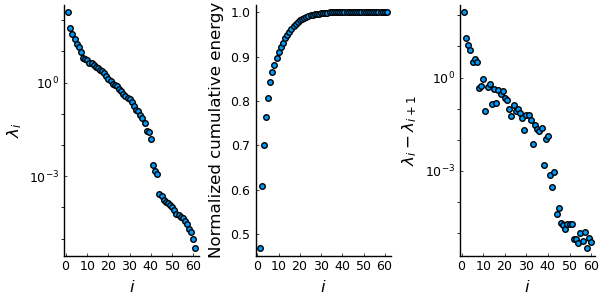

In [218]:
routine_spectrum(svd(Symmetric(Cx)).S)

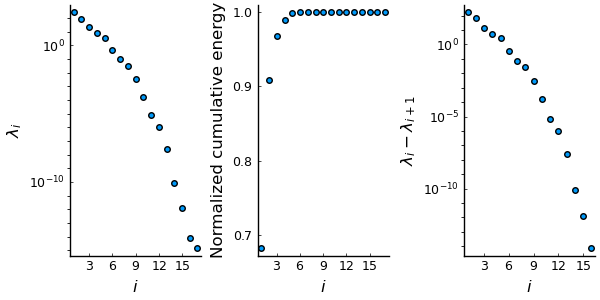

In [219]:
routine_spectrum(svd(Symmetric(Cy)).S)

In [18]:
# mean_rmse_lowrankenkf = 0.0
# nrun_lowrankenkf = 10

# for i=1:nrun_lowrankenkf
#     Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; rxdefault = 2, rydefault = Ny);
#     rmse_lowrankenkf = norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1))  
#     mean_rmse_lowrankenkf += (1/nrun_lowrankenkf)*rmse_lowrankenkf
#     @show rmse_lowrankenkf
# end

# mean_rmse_lowrankenkf

In [19]:
mean_rmse_lowrankenkf

LoadError: UndefVarError: mean_rmse_lowrankenkf not defined

In [ ]:
mean_rmse_enkf = 0.0
nrun_enkf = 10
for i=1:nrun_enkf
    Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data);
    rmse_enkf = norm(mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1))
    mean_rmse_enkf += (1/nrun_enkf)*rmse_enkf
    @show rmse_enkf
end
mean_rmse_enkf

In [42]:
J = analytical_jacobian_pressure(config.ss, state_to_lagrange(data.xt[:,20], config.zs, config), freestream, tf; issourcefixed = true)
Ji = J[:,vcat(collect(1:3*config.Nv), collect(6*config.Nv+1:6*config.Nv+config.Ns))]

9×25 Matrix{Float64}:
  0.00606773   -0.291198    0.281699    …  -0.0379541    0.0114917
  0.00254107    0.00116426  0.0762922      -0.0122632   -0.0038174
 -0.000520472   0.00646482  0.0323538       0.00187418  -0.0229774
 -0.000878378   0.00474279  0.0175309       0.00622476  -0.0398534
 -0.000816364   0.0033409   0.010909        0.00669701  -0.0495828
 -0.000693264   0.00242581  0.00741422  …   0.0060228   -0.0523233
 -0.000578539   0.00182457  0.00535558      0.00513848  -0.0508039
 -0.000483758   0.00141568  0.00404477      0.00432198  -0.0474156
 -0.000407746   0.00112747  0.00316027      0.00363544  -0.0435144

In [38]:
J[:,49]

9-element Vector{Float64}:
 -0.03698041211776645
 -0.04219683326464734
 -0.04394364560222073
 -0.040939798460009384
 -0.03465668891447302
 -0.027702741580873675
 -0.02166308523654501
 -0.016940094400938775
 -0.013389676868173194

In [37]:
Ji[:,24:25]

9×2 Matrix{Float64}:
 -0.0379538   -0.0369804
 -0.0122628   -0.0421968
  0.00187462  -0.0439436
  0.00622518  -0.0409398
  0.00669738  -0.0346567
  0.0060231   -0.0277027
  0.00513872  -0.0216631
  0.00432217  -0.0169401
  0.0036356   -0.0133897

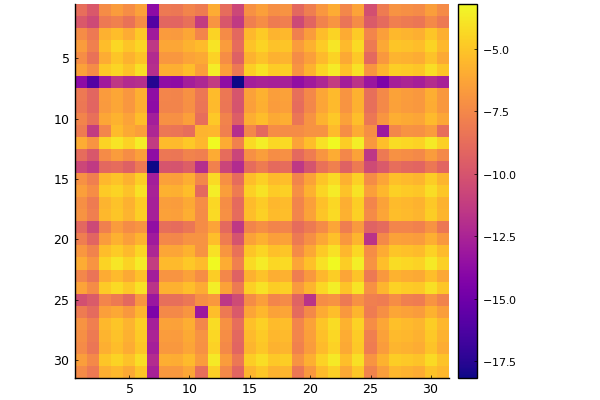

In [123]:
heatmap(1:Nx, 1:Nx, log.(abs.(Cx)), yflip = true, ratio = 1.0, xlim = (-Inf, Inf),
            colorbar = true, color = :plasma, background_color_inside = palette(:plasma)[1])

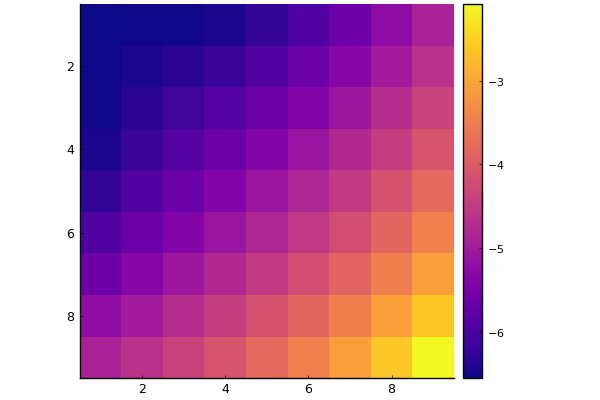

In [125]:
heatmap(log.(abs.(Cy)), yflip = true, ratio = 1.0, xlim = (-Inf, Inf),
            colorbar = true, color = :plasma, background_color_inside = palette(:plasma)[1])

In [126]:
Dx

31×31 Diagonal{Float64, Vector{Float64}}:
 0.00573152   ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅          0.00348148   ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅          0.00105627      ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
 ⋮                                   ⋱                          ⋮
  ⋅     

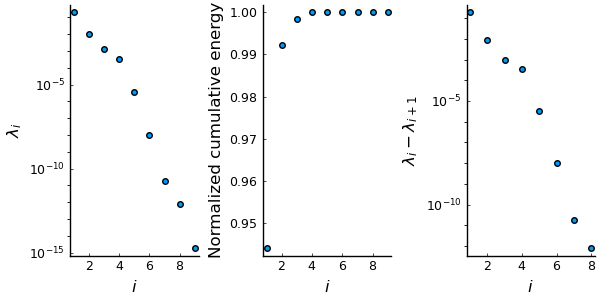

In [127]:
routine_spectrum(svd(Symmetric(Cy)).S)

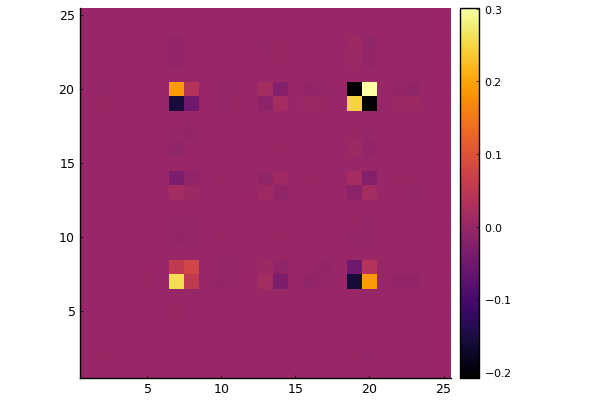

In [369]:
heatmap(cov(Xa[end]'), ratio = 1)

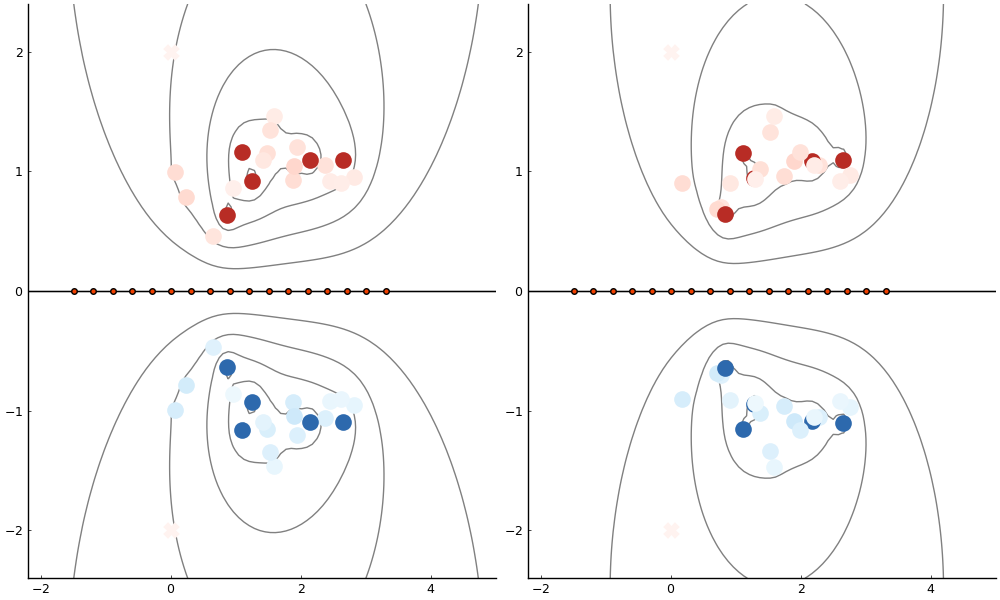

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [212]:
plt1 = routine_plot(data.xt[:,201], config, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(mean(Xalowrank[201]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
plot(plt1, plt2, size = (1000, 600))

In [371]:
function testrun(N)
    rmse_tab = zeros(N, Nx)
    Ncount = 0
    @inbounds for i=1:N
        for j=1:Nx
            Ncount += 1
            Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; rxdefault = j, rydefault = Ny)
            rmse_tmp = norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1))
            rmse_tab[i,j] = deepcopy(rmse_tmp)
            @show i, j, rmse_tmp
        end  
    end

    return rmse_tab
end

testrun (generic function with 1 method)

In [372]:
Nrun = 1
rmse_tab = testrun(Nrun)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


(i, j, rmse_tmp) = (1, 1, 1.7797774470103498)


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:02

LoadError: InterruptException:

In [359]:
plot(rmse_tab[1,:])

LoadError: UndefVarError: rmse_tab not defined

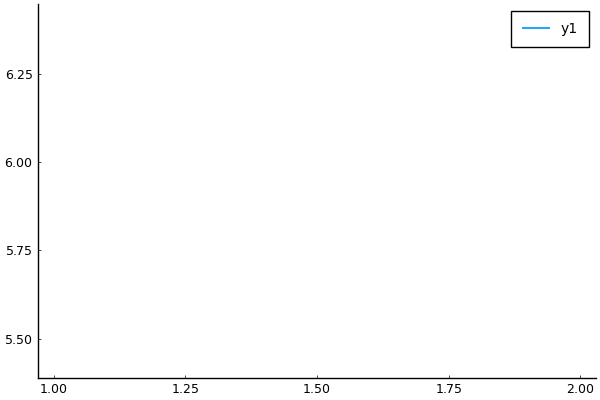

In [176]:
plot(median(rmse_tab; dims = 2)[:,1])

In [ ]:
Ne_tab = [20; 50; 70; 100; 120; 150; 200; 500]
Nrun = 10
@inbounds for Ne_tmp in Ne_tab
    @show Ne_tmp
    X0 = zeros(Ny+Nx, Ne_tmp)
    X0[Ny+1:Ny+Nx,:] .= deepcopy(data.x0)
    ϵ0(X0, Ny, Nx)
    rmse_tab = zeros(Nrun, Nx)
    for i=1:Nrun
        for j=1:Nx
            Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; rxdefault = j, rydefault = Ny)
            rmse_i = norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1))
            rmse_tab[i,j] = deepcopy(rmse_i)
        end  
    end
    save("rmse_Nrun_"*string(Nrun)*"_Ne_"*string(Ne_tmp)*".jld", "rmse", deepcopy(rmse_tab))
end 

Ne_tmp = 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 

Ne_tmp = 50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 

Ne_tmp = 70


Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 

Ne_tmp = 100


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 

Ne_tmp = 120


Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 

In [178]:
# Plot with rescaling and Cx and Cy
plt = plot(layout = grid(1, 2))
plot!(plt[1,1], 1:Nx, rmse_tab, xlabel = "rank "*latexstring("r_X"), ylabel = "RMSE", 
      label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf), legend = :outertop)
hline!(plt[1,1], [rmse_tab[end]], label = "full rank")
plot!(plt[1,2], 1:Nx, rmse_tab, yscale = :log10, xlabel = "rank "*latexstring("r_x"), 
      ylabel = "RMSE", label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf))
hline!(plt[1,2], [rmse_tab[end]], label = "full rank", legend = :outertop)
# savefig("plot_rmse_rank3.pdf")

LoadError: Expects 25 elements in each col of y, found 1.

In [179]:
# Plot without rescaling and without Cy

plt = plot(layout = grid(1, 2))
plot!(plt[1,1], 1:Nx, rmse_tab, xlabel = "rank "*latexstring("r_X"), ylabel = "RMSE", 
      label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf), legend = :outertop)
hline!(plt[1,1], [rmse_tab[end]], label = "full rank")
plot!(plt[1,2], 1:Nx, rmse_tab, yscale = :log10, xlabel = "rank "*latexstring("r_x"), 
      ylabel = "RMSE", label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf))
hline!(plt[1,2], [rmse_tab[end]], label = "full rank", legend = :outertop)
# savefig("plot_rmse_rank2.pdf")

LoadError: Expects 25 elements in each col of y, found 1.

In [360]:
plot(norm.(eachcol((mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1)))))
plot!(norm.(eachcol((mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1)))))

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(31), Base.OneTo(401)), b has dims (Base.OneTo(25), Base.OneTo(401)), mismatch at 1")

In [168]:
100*(rmse_enkf - rmse_lowrankenkf)/rmse_enkf

-40.125336922503585

In [373]:
cumsum(svd(Symmetric(Cx)).S) ./ sum(svd(Symmetric(Cx)).S)

25-element Vector{Float64}:
 0.6619888437926841
 0.8477771243603104
 0.9458249324887349
 0.9744949568364281
 0.9863407313059299
 0.9967358800745958
 0.9983973706029737
 0.999333008538623
 0.999791200039511
 0.9998522069254409
 0.9999048221933542
 0.99994073200833
 0.9999636645808224
 0.9999800540428886
 0.9999918298456081
 0.9999989618545169
 0.9999996382120458
 0.9999997782542481
 0.999999862390587
 0.999999940627871
 0.9999999660193148
 0.9999999860680941
 0.9999999951155185
 0.9999999995138837
 1.0

In [374]:
cumsum(svd(Symmetric(Cy)).S) ./ sum(svd(Symmetric(Cy)).S)

9-element Vector{Float64}:
 0.7838785290239051
 0.986489919245771
 0.99914452425824
 0.9999758626542511
 0.9999996256524059
 0.9999999725346367
 0.9999999995530325
 0.9999999999999486
 0.9999999999999999

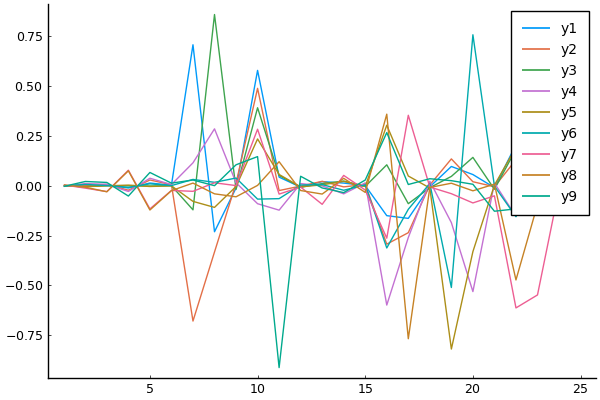

In [375]:
plot(svd(Symmetric(Cx)).U[:,1:9])

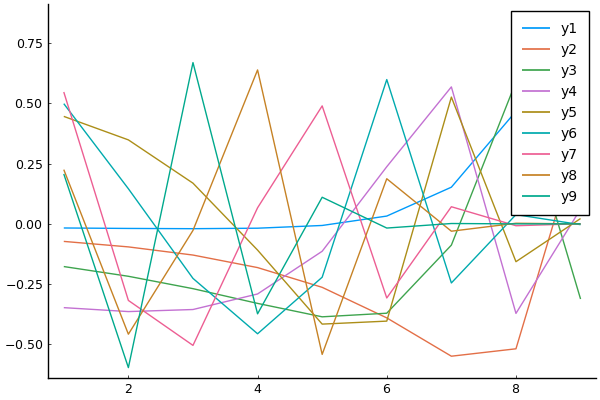

In [376]:
plot(svd(Symmetric(Cy)).U[:,1:9])

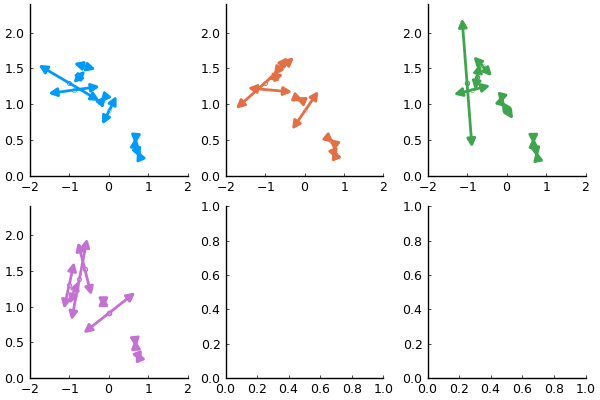

In [377]:
routine_plotCx(mean(Xa[101]; dims= 2)[:,1], Cx, 4, config, xgrid, ygrid; withvortices = true)

In [378]:
Xtmp = deepcopy(Xflowrank[end])
ϵx = RecipeInflation([config.ϵX; config.ϵΓ; config.ϵQ])
ϵmul = MultiplicativeInflation(config.β)

ϵmul(Xtmp, 1, Nx)
for i=1:Ne
    ϵx(view(Xtmp,:,i))
end
Y = hcat(map(i->measure_state(Xtmp[:,i], tf, config), 1:Ne)...)

9×50 Matrix{Float64}:
 -0.473552  -0.47357   -0.472887  …  -0.473874  -0.472291  -0.474003
 -0.46884   -0.468498  -0.468216     -0.468707  -0.467496  -0.469362
 -0.463024  -0.462049  -0.46249      -0.462107  -0.461576  -0.463619
 -0.456029  -0.453949  -0.455612     -0.453815  -0.454346  -0.456675
 -0.448296  -0.444178  -0.447996     -0.443801  -0.4461    -0.448917
 -0.44217   -0.433984  -0.441922  …  -0.433209  -0.439044  -0.442573
 -0.446543  -0.430055  -0.445939     -0.428449  -0.442071  -0.446447
 -0.491188  -0.460895  -0.489257     -0.458101  -0.486269  -0.491129
 -0.65505   -0.6237    -0.655926     -0.623265  -0.658025  -0.657508

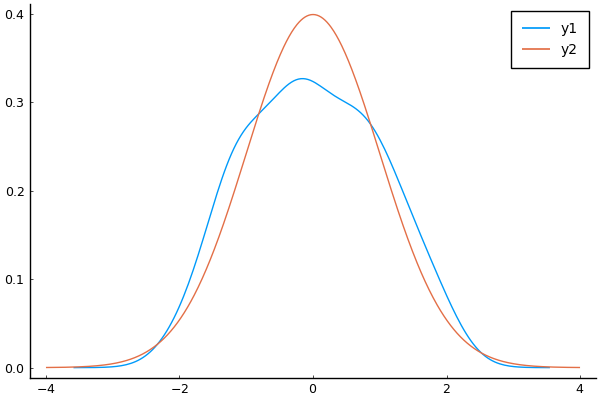

In [379]:
density(transform(Y[4:4,:])[1,:])
plot!(-4.0:0.01:4.0, map(x->1/sqrt(2*π)*exp(-0.5*x^2), -4.0:0.01:4.0))

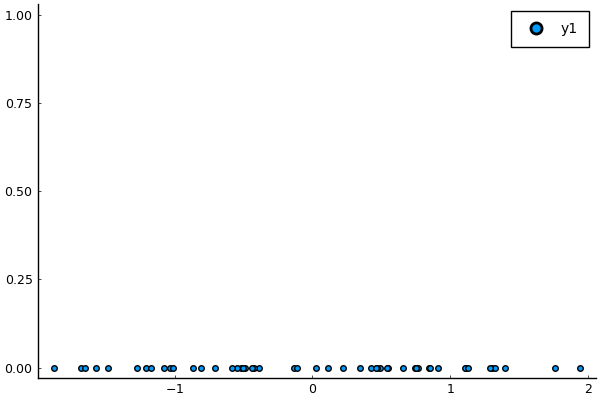

In [380]:
scatter(transform(Xalowrank[201][9:9,:])[1,:], zeros(Ne))

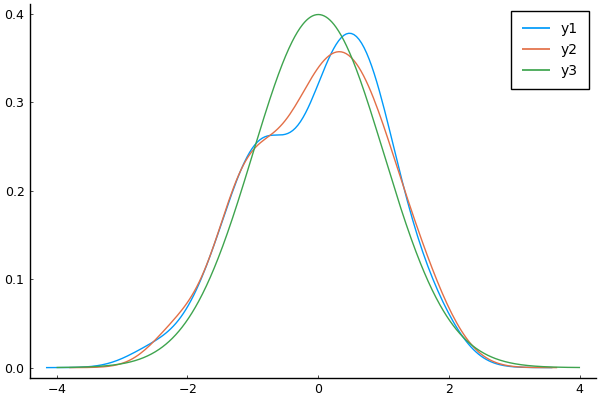

In [381]:
density(transform(Xa[401][9:9,:])[1,:])
density!(transform(Xalowrank[401][9:9,:])[1,:])
plot!(-4.0:0.01:4.0, map(x->1/sqrt(2*π)*exp(-0.5*x^2), -4.0:0.01:4.0))

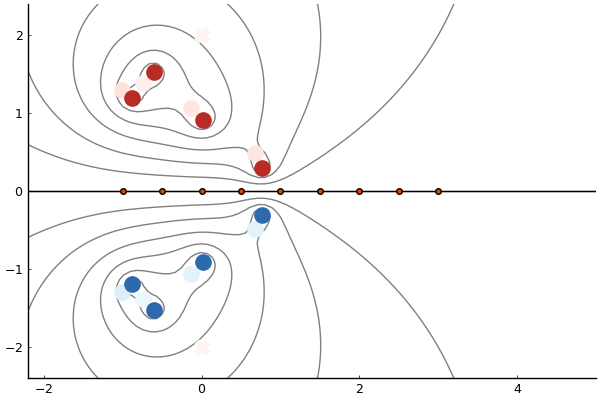

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [382]:
routine_plot(mean(Xa[101]; dims= 2)[:,1], config, xgrid, ygrid; withvortices = true)

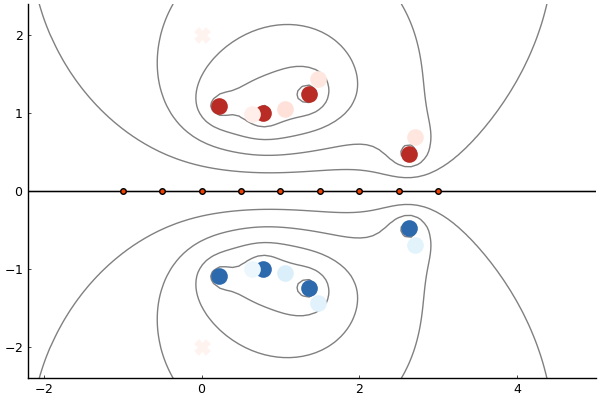

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [385]:
plt = plot(layout = grid(1,2))
routine_plot(mean(Xalowrank[201]; dims= 2)[:,1], config, xgrid, ygrid; withvortices = true)

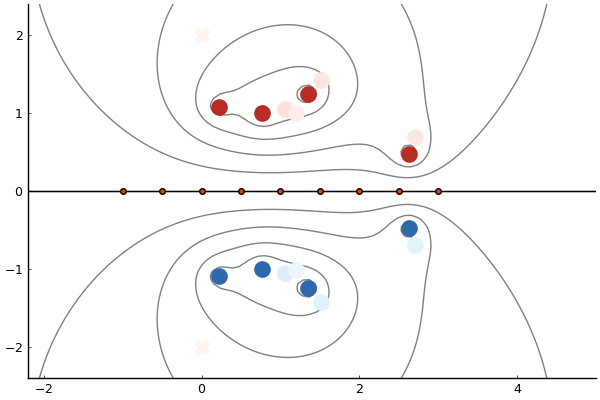

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [386]:
routine_plot(data.xt[:,201], config, xgrid, ygrid; withvortices = true)

In [271]:
maximum(Xalowrank[end])

4.226257652563084

In [254]:
# prog = Progress(length(t0:Δtgif:tf))

# @gif for tsnap in t0:Δtgif:tf
#     nsnap = ceil(Int64, tsnap/config.Δt)+1
    
#     Ysnap = hcat(map(xi -> measure_state(xi, 1.0, config), eachcol(Xa[nsnap]))...)
# #     plt1 = routine_plot(data.xt[:,nsnap], config, xgrid, ygrid)
#     plt2 = routine_plot(mean(Xalowrank[nsnap]; dims = 2)[:,1], config, xgrid, ygrid)
#     plt3 = plot(xlim = (-Inf, Inf), 
#                 linewidth = 2, ylim = (-4.0, 0.0), legend = false, xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
#     plot!(plt3, real(config.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config), 
#           linewidth = 2, color = :navyblue)
#     plot!(plt3, real(config.ss), 2*mean(Ysnap; dims = 2)[:,1],
#           linewdith = 2, color = :orangered, linestyle = :dash, ribbon = 2*std(Ysnap; dims = 2)[:,1])
#     plot(plt2, plt3)
#     next!(prog)
# end

In [273]:
maximum(vcat(Xalowrank...))

4.226257652563084

In [253]:
# prog = Progress(length(t0:Δtgif:tf))

# @gif for tsnap in t0:Δtgif:tf
#     nsnap = ceil(Int64, tsnap/config.Δt)+1
    
#     Ysnap = hcat(map(xi -> measure_state(xi, 1.0, config), eachcol(Xa[nsnap]))...)
#     plt1 = routine_plot(mean(Xa[nsnap]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
#     plt2 = plot(xlim = (-Inf, Inf), 
#                 linewidth = 2, ylim = (-4.0, 0.0), xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
#     plot!(plt2, real(config.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config), 
#           linewidth = 2, color = :navyblue, label = "Truth")
#     plot!(plt2, real(config.ss), 2*mean(Ysnap; dims = 2)[:,1],
#           linewdith = 2, color = :orangered, linestyle = :dash, ribbon = 2*std(Ysnap; dims = 2)[:,1], label = "EnKF")
#     plot(plt1, plt2)
#     next!(prog)
# end

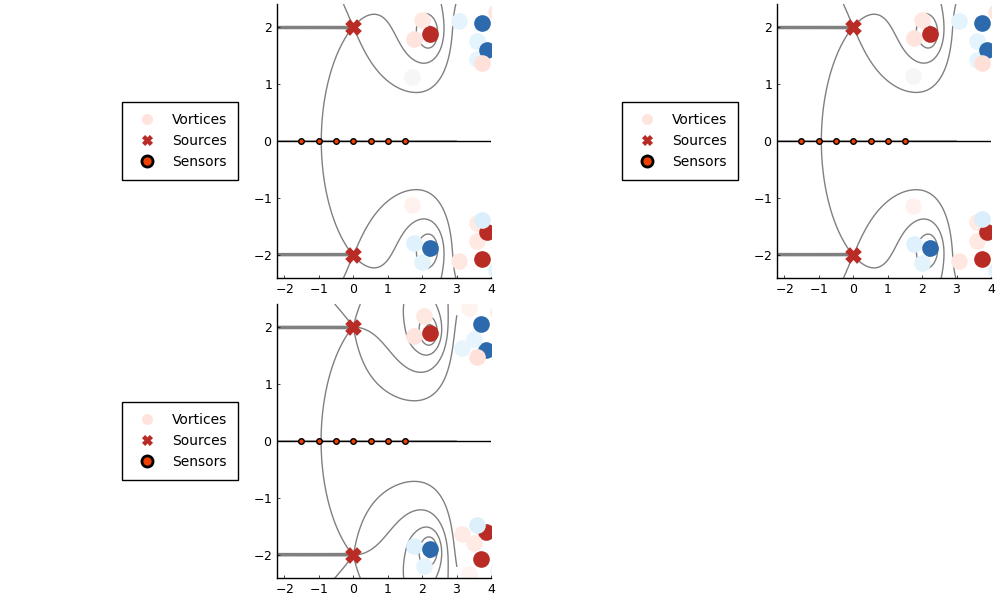

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [275]:
plt1 = routine_plot(data.xt[:,401], config, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(mean(Xa[401]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
plt3 = routine_plot(mean(Xalowrank[401]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
plot(plt1, plt2, plt3, size = (1000, 600))

In [255]:
# prog = Progress(length(t0:Δtgif:tf))

# @gif for tsnap in t0:Δtgif:tf
#     nsnap = ceil(Int64, tsnap/config.Δt)+1
    
#     Ysnap = hcat(map(xi -> measure_state(xi, 1.0, config), eachcol(Xa[nsnap]))...)
#     plt1 = routine_plot(data.xt[:,nsnap], config, xgrid, ygrid; withvortices = true)
#     plt2 = routine_plot(mean(Xa[nsnap]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
#     plt3 = routine_plot(mean(Xalowrank[nsnap]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)

#     plot(plt1, plt2, plt3)
#     next!(prog)
# end

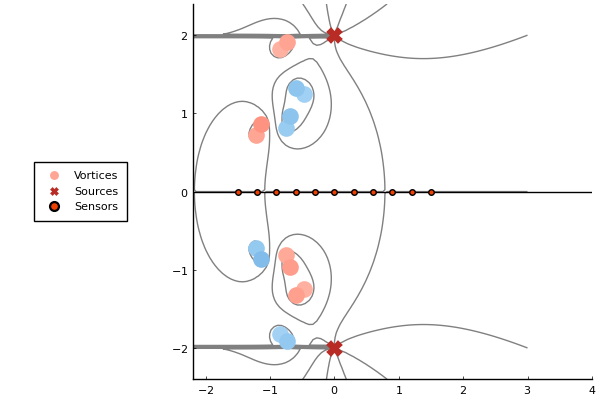

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [93]:
routine_plot(mean(Xa[101]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)

In [178]:
measure_state(data.xt[:,end], tf, config)-measure_state(mean(Xa[end]; dims = 2)[:,1], tf, config)

14-element Vector{Float64}:
 -0.0011000356557158142
 -0.0011860747784697145
 -0.0012771207647282456
 -0.0013722130283266298
 -0.0014709931164431644
 -0.001575197338241796
 -0.0016904663639493722
 -0.0018271489445737532
 -0.001998868911010754
 -0.002219917575396413
 -0.0025056555954941495
 -0.002883167366943107
 -0.0034283646269996915
 -0.004367460328834616

In [179]:
map(xi-> measure_state(xi, tf, config), eachcol(Xa[end]))[1]

14-element Vector{Float64}:
 -0.4807215752386348
 -0.47872728766790523
 -0.47641499344182936
 -0.47371708741895213
 -0.47055033441545585
 -0.46681345065072644
 -0.4623843272914594
 -0.45711574747640155
 -0.4508296347355466
 -0.4433152775545013
 -0.4343469075408013
 -0.42375431954638065
 -0.4116284182156947
 -0.39888358088778775

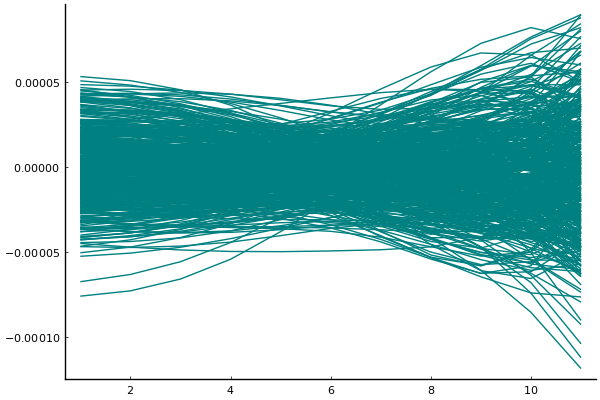

In [96]:
plot(map(xi-> measure_state(xi, tf, config)  - measure_state(mean(Xa[end]; dims=2)[:,1], tf, config), 
        eachcol(Xa[end])),
        color = :teal, linewdith = 2, legend = false)
# plot!(measure_state(data.xt[:,end], tf, config), linewidth = 2,
#       color = :orangered2, linestyle = :dash)

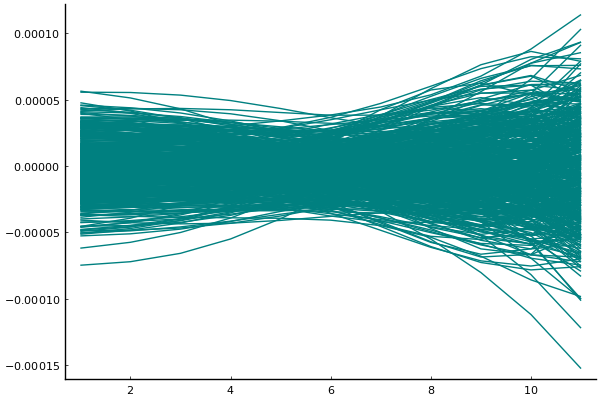

In [97]:
plot(map(xi-> measure_state(xi, tf, config)  - measure_state(mean(Xf[end]; dims=2)[:,1], tf, config), 
        eachcol(Xf[end])),
        color = :teal, linewdith = 2, legend = false)

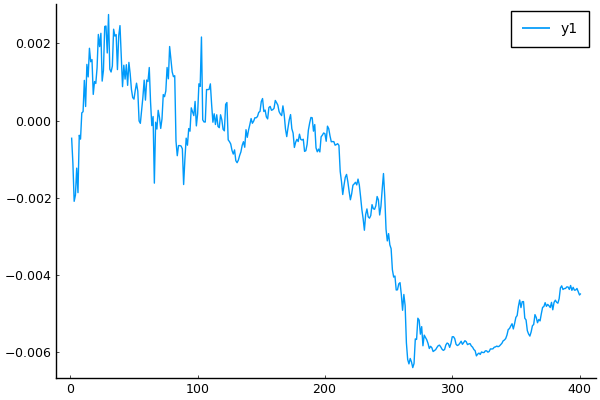

In [177]:
plot(hcat(mean.(Xalowrank; dims = 2)...)[end,:])

In [99]:
J = jacobian_pressure(config.ss, state_to_lagrange(Xa[end][:,1], config.zs, config), freestream, tf)

11×50 Matrix{Float64}:
 -0.00536145  0.00205991   0.000112305  …   0.0368174    0.0368174
 -0.00639636  0.00255385   0.000215395      0.0344128    0.0344128
 -0.00767256  0.00317286   0.000281816      0.0299923    0.0299923
 -0.00923541  0.00395668   0.000274169      0.0230978    0.0230978
 -0.0111257   0.00496496   0.000164268      0.0136464    0.0136464
 -0.0133621   0.00628038  -2.92156e-5   …   0.00224315   0.00224315
 -0.0158905   0.0079871   -0.000190207     -0.00977374  -0.00977374
 -0.0184551   0.0100861   -5.74489e-5      -0.0207658   -0.0207658
 -0.0203482   0.0122953    0.000813784     -0.0294591   -0.0294591
 -0.0201104   0.0137285    0.00306654      -0.035333    -0.035333
 -0.015625    0.0127493    0.00740562   …  -0.0385594   -0.0385594

In [110]:
 cumsum(svd(Symmetric(Cx)).S)./sum(svd(Symmetric(Cx)).S)

25-element Vector{Float64}:
 0.6681933665414967
 0.9160547060782901
 0.9785203974384282
 0.9969743624810625
 0.998975448878397
 0.9993131131933654
 0.9995550600421969
 0.9996629041135013
 0.9997512839474035
 0.9998143491994708
 0.999860559873983
 0.9998957771067523
 0.9999211007719049
 0.9999386708140486
 0.9999539200548163
 0.9999667007110551
 0.9999771784956322
 0.999983822537578
 0.9999894316407507
 0.9999925475543354
 0.9999950055088012
 0.999996752715211
 0.9999979315653077
 0.9999990336635767
 0.9999999999999999